### Mamba Visualization/Interp Tools

Includes: stuff

In [1]:
print("henlo")

henlo


In [8]:
import plotly.io as pio
import plotly.offline as pyo
pyo.init_notebook_mode()
import matplotlib
%matplotlib inline


### optional (fast_conv and fast_ssm) ###

## install cuda
# if you are on a devbox, use
# sudo apt install wget
# wget https://developer.download.nvidia.com/compute/cuda/12.0.0/local_installers/cuda_12.0.0_525.60.13_linux.run
# sudo sh cuda_12.0.0_525.60.13_linux.run
# add /usr/local/cuda-12.0/bin/ to PATH
# that gives u nvcc

## fast_conv=True
# if you want fast_conv=True you need to install
# https://github.com/Dao-AILab/causal-conv1d
# via
# pip install causal-conv1d

## fast_ssm=True
# if you want fast_ssm=True you need to install
# https://github.com/state-spaces/mamba
# via
# pip install mamba-ssm


### install plotly ###

# if plotly isn't working, i did
# install nvm from
# https://github.com/nvm-sh/nvm
# and activate it
# then i did
# nvm install node
# jupyter labextension install plotlywidget

# if the jupyter widgets aren't working i have no recommendations
# only god can help you

# Import stuff
import torch
from functools import partial
import transformer_lens.utils as utils
import plotly.express as px
torch.set_grad_enabled(False)
device = utils.get_device()
# from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, **kwargs):
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = kwargs['x'],
            ticktext = kwargs['x'], 
            ),
           font=dict(size=font_size, color="black"))
    fig.show(renderer)

def show(data, x, xaxis, yaxis, title, clipped):
    if clipped:
        imshow(data[:,2:], x=x[2:], xaxis=xaxis, yaxis=yaxis, title=title)
    else:
        imshow(data, x=x, xaxis=xaxis, yaxis=yaxis, title=title)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [3]:
# load mamba
import os
from mamba_lens import HookedMamba
import os
import datetime
model = HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')

Time since last modify 2 days, 23:02:01.950455


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


### Test: Compare to reference mamba to make sure you didn't mess up code

In [29]:
modelref = mamba.Mamba.from_pretrained("state-spaces/mamba-370m", device=device)
print(modelref.forward(torch.tensor([[1,2]]).to(device)))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tensor([[[ 2.4702, -8.5650,  2.6273,  ..., -8.6552, -8.6197, -8.6892],
         [ 7.6153, -8.1547,  4.8064,  ..., -8.2490, -8.1721, -8.4460]]],
       device='cuda:0')


In [ ]:
hooked_mamba.test_fast_grads(model=model)

Error: grads not the same for param embedding.weight
Non fast grads: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.8099,  0.7631, -1.4781,  ..., -1.9443, -1.0059, -1.6681],
        [ 0.0778,  0.1830,  0.3185,  ..., -0.1987, -0.0901,  0.1274],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
grads for fast_conv=False, fast_ssm=True tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.8070,  0.7602, -1.4762,  ..., -1.9446, -1.0055, -1.6685],
        [ 0.0793,  0.1818,  0.3195,  ..., -0.1988, -0.0898,  0.1273],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]

In [28]:
original_cfg = {
    'd_model': 3,
    'n_layer': 3,
    'vocab_size': 48,
    'ssm_config': {
        'd_state': 16
    },
    'initializer_cfg': {
        'initializer_range': 0.5,  # Now only used for embedding layer.
        'rescale_prenorm_residual': False,
        'n_residuals_per_layer': 3,  # Change to 2 if we have MLP
        'dt_init': 'totes', # other option is "constant"
        'dt_scale': 3.5,
        'dt_min': 0.022,
        'dt_max': 0.4,
        'dt_init_floor': 1e-1
    }
}
import hooked_mamba
from importlib import reload
reload(hooked_mamba)
hooked_cfg = hooked_mamba.convert_original_config_to_hooked_mamba_config(original_cfg)
print(hooked_cfg)
original_back_cfg = hooked_mamba.convert_hooked_mamba_config_to_original_config(hooked_cfg)

def compare_dicts(original, converted):
    for k in set(list(original.keys()) + list(converted.keys())):
        if not k in original:
            print("Error: added new key", k, "that was not in original config")
        if not k in converted:
            print("Error: lost key", k, "which was in original config but is not after convert and convert back")
        if k in original and k in converted and original[k] != converted[k]:
            print(f"Error: key {k} was originally value {original[k]} but after convert is now {converted[k]}")

compare_dicts(original_cfg, original_back_cfg)
compare_dicts(original_cfg['initializer_cfg'], original_back_cfg['initializer_cfg'])


MambaCfg(d_model=3, n_layers=3, vocab_size=48, d_state=16, expand=2, dt_rank=1, d_conv=4, pad_vocab_size_multiple=8, conv_bias=True, bias=False, default_prepend_bos=True, tokenizer_prepends_bos=False, n_ctx=2048, device='cuda', initializer_cfg=MambaInitCfg(initializer_range=0.5, rescale_prenorm_residual=False, n_residuals_per_layer=3, dt_init='totes', dt_scale=3.5, dt_min=0.022, dt_max=0.4, dt_init_floor=0.1), d_inner=6)
Error: added new key pad_vocab_size_multiple that was not in original config
Error: added new key expand that was not in original config
Error: added new key dt_rank that was not in original config
Error: added new key d_conv that was not in original config
Error: added new key bias that was not in original config
Error: added new key n_ctx that was not in original config
Error: added new key d_inner that was not in original config
Error: added new key tokenizer_prepends_bos that was not in original config
Error: added new key conv_bias that was not in original config


In [43]:
import itertools
for fast_conv, fast_ssm in itertools.product([True, False], [True, False]): 
    print(f"fast_conv {fast_conv} and fast_ssm {fast_ssm}")
    print(model.forward(torch.tensor([[1,2]]), fast_ssm=fast_ssm, fast_conv=fast_conv))

fast_conv True and fast_ssm True
tensor([[[ 2.4702, -8.5650,  2.6273,  ..., -8.6552, -8.6197, -8.6892],
         [ 7.6153, -8.1547,  4.8064,  ..., -8.2490, -8.1721, -8.4460]]],
       device='cuda:0')
fast_conv True and fast_ssm False
tensor([[[ 2.4702, -8.5650,  2.6273,  ..., -8.6552, -8.6197, -8.6892],
         [ 7.6153, -8.1547,  4.8064,  ..., -8.2490, -8.1721, -8.4460]]],
       device='cuda:0')
fast_conv False and fast_ssm True
tensor([[[ 2.4702, -8.5650,  2.6273,  ..., -8.6552, -8.6197, -8.6892],
         [ 7.6153, -8.1547,  4.8064,  ..., -8.2490, -8.1721, -8.4460]]],
       device='cuda:0')
fast_conv False and fast_ssm False
tensor([[[ 2.4702, -8.5650,  2.6273,  ..., -8.6552, -8.6197, -8.6892],
         [ 7.6153, -8.1547,  4.8064,  ..., -8.2490, -8.1721, -8.4460]]],
       device='cuda:0')


### Test: State Dict conversion

In [123]:
import mamba
from importlib import reload
reload(mamba)
mamba.test_state_dict_convert()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda
all tests passed


### Test: Make sure there's no in-place stuff that'll mess up patching

In [3]:
import itertools
# This test compares cached things with outputs from run_with_cache
# it detects if there was in-place modification changing the output of run_with_hooks after things are stored
# (a bug that causes issues when doing patching)

for fast_conv, fast_ssm in itertools.product([True, False], [True, False]):
    print(f"running test for fast_conv {fast_conv} and fast_ssm {fast_ssm}")
    manual_cache = {}
    
    def save_hook(tensor, hook):
        manual_cache[hook.name] = tensor.detach().to(model.cfg.device).clone()
        return tensor.clone()
    
    
    input = torch.tensor([[1,2,3]], device=model.cfg.device)
    model_args = [input]
    fwd_hooks = []
    bwd_hooks = []
    # fwd_hooks=None expands all input_dependent hooks
    # we need this context to get the input dependent hooks
    with model.input_dependent_hooks_context(fwd_hooks=None, bwd_hooks=None, model_args=model_args, model_kwargs={}):
        for name, hp in model.hook_dict.items():
            fwd_hooks.append((name, save_hook))
    
    manual_cache_logit = model.run_with_hooks(
        input,
        fwd_hooks=fwd_hooks,
        bwd_hooks=bwd_hooks,
        fast_ssm=fast_ssm,
        fast_conv=fast_conv,
        warn_disabled_hooks=False,
    )
    
    run_with_cache_logit, run_with_cache_cache = model.run_with_cache(input, fast_ssm=fast_ssm, fast_conv=fast_conv,warn_disabled_hooks=False)
    
    any_mismatch = False
    for k in manual_cache.keys():
        manual_value = manual_cache[k]
        run_with_cache_value = run_with_cache_cache[k]
        if torch.any(manual_value != run_with_cache_value):
            print("mismatch for key", k, "do you modify it in place?")
            any_mismatch = True
    if not any_mismatch:
        print("test passed, patching is safe")
        


running test for fast_conv True and fast_ssm True
test passed, patching is safe
running test for fast_conv True and fast_ssm False
test passed, patching is safe
running test for fast_conv False and fast_ssm True
test passed, patching is safe
running test for fast_conv False and fast_ssm False
test passed, patching is safe


### Timing code for optimizations

In [140]:
%timeit model.forward(torch.tensor([[1,2,3,4,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]]), fast_ssm=True, warn_disabled_hooks=True)

36.7 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
a = torch.randn([5,4])


class B(object):
    def __getitem__(self, a):
        print(a)
        return 'wow'

a = B()
a[1,3]

(1, 3)


'wow'

# General Purpose Plotter

In [50]:
import re
from collections import defaultdict
from dataclasses import dataclass
import itertools
import ipywidgets
from IPython.display import display, clear_output
from transformer_lens.hook_points import HookPoint
input = torch.tensor([[1,2,3]], device=model.cfg.device)
model_args = [input]

prompt = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens = model.to_tokens(prompt)
logits, activations = model.run_with_cache(prompt_tokens)
token_labels = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens[0]))]


activations = dict(list(activations.items()))

for name, param in model.named_parameters():
    activations["param " + name] = param.data

POS_PARAM = 'pos'

bonus_params = {
    'layer': list(range(model.cfg.n_layers)),
    POS_PARAM: list(range(len(prompt_tokens))),
}

bonus_params_tensor_dimension_lookup = {
    'layer': -1,
    POS_PARAM: -2,
}

hook_params = defaultdict(lambda: defaultdict(lambda: set()))
lookup_by_no_digits = defaultdict(lambda: [])
for hook_name in activations.keys():
    digits = re.findall('\.\d+', hook_name)
    params = {}
    if len(digits) == 1:
        params['layer'] = digits[0]
    elif len(digits) == 2:
        params['layer'], params[POS_PARAM] = digits
    elif len(digits) > 2:
        raise ValueError(f"Only implemented support for hooks with layer and pos index, you have {hook_name} which has digits of {digits}")
   
    #print(hook_name, digits, params)
    
    no_digits_name = re.sub("\.\d+", "*", hook_name)
    for param, value in params.items():
        hook_params[no_digits_name][param].add(value)

    lookup_by_no_digits[no_digits_name].append((params, hook_name))


#print("hook params")
#for k,v in hook_params.items():
#    print(k,v)

#print("lookup_by_no_digits")
#for k,v in lookup_by_no_digits.items():
#    print(k,v)

L = len(prompt_tokens[0])
dimensions = {
    model.cfg.E: "e",
    model.cfg.N: "n",
    model.cfg.D: "d",
    model.cfg.dt_rank: "d_delta",
    L: POS_PARAM,
}

dimension_size_lookup = {
    "e": model.cfg.E,
    "n": model.cfg.N,
    "d": model.cfg.D,
    "d_delta": model.cfg.dt_rank,
    POS_PARAM: L,
    "layer": model.cfg.n_layers
}

def get_pretty_hook_name(hook_name):
    return hook_name.replace(".norm", ".layernorm").replace("blocks", "").replace("hook_", "").replace("*", "").replace(".weight", "").replace(".", "")

hooks = sorted(list(lookup_by_no_digits.keys()))
pretty_hooks = [get_pretty_hook_name(name) for name in hooks]


batch_graph_options = range(1, 20)
batch_dropdown = ipywidgets.Dropdown(
    options=batch_graph_options,
    value=batch_graph_options[0],
    description='batch big',
)

hook_dropdown = ipywidgets.Dropdown(
    options=pretty_hooks,
    value=pretty_hooks[0],
    description='hook',
)


@dataclass
class HookParam:
    name: str
    tensor_dimension_index: int = 0


def modify_plot_widgets(param_x, param_y, params, hook_name):
    with output_inner:
        clear_output()
        not_using_params = [x for x in params if not x in [param_x, param_y]]
        #print(not_using_params)
        param_dropdowns = []
        
        def refresh_plot():
            with output_plot:
                clear_output()
                # we need to roll up data over layer
                if any([param.name == 'layer' for param in params]):
                    layer_outputs = []
                    for layer in range(model.cfg.n_layers):
                        layer_hook_name = hook_name.replace("*", "." + str(layer), 1) # only replace first instance of *
                        if "*" in layer_hook_name: # index
                            layer_output = []
                            for l in range(L):
                                layer_index_hook_name = layer_hook_name.replace("*", "." + str(l))
                                layer_output.append(activations[layer_index_hook_name])
                            # stack along the last dimension
                            layer_output = torch.stack(layer_output, dim=-1)
                        else: # just layer
                            layer_output = activations[layer_hook_name]
                        layer_outputs.append(layer_output)
                    params_to_plot = torch.stack(layer_outputs, dim=-1)
                else:
                    params_to_plot = activations[hook_name]

                def convert_index(i):
                    if i < 0:
                        return len(params_to_plot.size())+i
                    else:
                        return i
                        
                dim_index_lookup = {}
                dim_index_str_lookup = {}
                param_strs = []
                for dropdown, param in zip(param_dropdowns, not_using_params):
                    value = int(dropdown.value)
                    index = convert_index(param.tensor_dimension_index)
                    dim_index_lookup[index] = value
                    dim_index_str_lookup[index] = param.name
                    param_strs.append(param.name + "=" + str(value))
                for param in [param_x, param_y]:
                    index = convert_index(param.tensor_dimension_index)
                    empty_slice = slice(None, None, None) # equivalent to [:]
                    dim_index_lookup[index] = empty_slice
                    dim_index_str_lookup[index] = param.name

                # batch index
                if params_to_plot.size()[0] == 1:
                    dim_index_lookup[0] = 0
                    dim_index_str_lookup[0] = 'batch'

                index = []
                index_str = []
                for i in range(len(params_to_plot.size())):
                    index.append(dim_index_lookup[i])
                    index_str.append(dim_index_str_lookup[i])
                index = tuple(index)
                
                output_data = params_to_plot.__getitem__(index) # this is [index]

                x_size = dimension_size_lookup[param_x.name]
                y_size = dimension_size_lookup[param_y.name]

                output_data_size = output_data.size()
                if output_data_size[0] == y_size: # needs to be transposed
                    output_data = output_data.T

                small_hook_name = get_pretty_hook_name(hook_name)
                param_str = " ".join(param_strs)
                index_str = "[" + ", ".join([name for name in index_str if name != 'batch']) + "]"
                title = f'{small_hook_name}{index_str} {param_str}'

                x, y = None, None
                if param_x.name == POS_PARAM:
                    x = token_labels
                if param_y.name == POS_PARAM:
                    y = token_labels

                # plotly wants it transposed
                output_data = output_data.T
                
                def imshow_helper(tensor, x_range=None, y_range=None, renderer=None, xaxis="", yaxis="", **kwargs):
                    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
                    #if param_x.name == POS_PARAM:
                    #    fig.update_xaxes({"dtick": 1})
                    #if param_y.name == POS_PARAM:
                    #    fig.update_yaxes({"dtick": 1})
                    #if not x_range is None:
                    #    fig.update_layout(xaxis_range=x_range)
                    #if not y_range is None:
                    #    fig.update_layout(yaxis_range=y_range)
                    fig.show(renderer)

                batch = int(batch_dropdown.value)
                if batch == 1:
                    imshow_helper(output_data, x=x, y=y, xaxis=param_x.name, yaxis=param_y.name, title=title)
                else:
                    if x_size < y_size:
                        batch_size = y_size // batch
                        for batch_start in range(0, y_size, batch_size):
                            batch_end = min(batch_start+batch_size, y_size)
                            plot_data = output_data[batch_start:batch_end,:]
                            batch_y = None
                            if not y is None:
                                batch_y = y[batch_start:batch_end]
                            else:
                                batch_y = list(range(y_size))[batch_start:batch_end]
                            imshow_helper(output_data[batch_start:batch_end,:], y_range=[batch_start,batch_end], x=x, y=batch_y, xaxis=param_x.name, yaxis=param_y.name, title=title)
                    else:
                        batch_size = x_size // batch
                        for batch_start in range(0, x_size, batch_size):
                            batch_end = min(batch_start+batch_size, x_size)
                            plot_data = output_data[batch_start:batch_end,:]
                            batch_x = None
                            if not x is None:
                                batch_x = x[batch_start:batch_end]
                            
                            imshow_helper(output_data[:,batch_start:batch_end], x_range=[batch_start,batch_end], x=batch_x, y=y, xaxis=param_x.name, yaxis=param_y.name, title=title)
                        
        def refresh_plot_widget_callback(change):
            if change['type'] == 'change' and change['name'] == 'value':
                refresh_plot()
                
        for not_using_param in not_using_params:
            name = not_using_param.name
            dim_size = dimension_size_lookup[name]
            param_options = list(range(dim_size))
            param_dropdown = ipywidgets.Dropdown(
                options=param_options,
                value=param_options[0],
                description=name,
            )
            param_dropdowns.append(param_dropdown)
            param_dropdown.observe(refresh_plot_widget_callback)
            display(param_dropdown)
        refresh_plot()

        

def modify_dimension_widgets(hook_name):
    with output:
        clear_output()

        example_params, example_hook_name = lookup_by_no_digits[hook_name][0]
        example_value = activations[example_hook_name]
        dims = example_value.size()
        #print("dims", dims)
        params = []
        dim_lookup = {}
        for i,d in enumerate(dims):
            if d == 1:
                dim_lookup[i] = 'batch'
            else:
                dim_lookup[i] = dimensions[d]
                params.append(HookParam(name = dimensions[d],
                          tensor_dimension_index=i))
                #print(i, dim_lookup[i])
        
        for param_name, param_value in example_params.items():
            if param_name in bonus_params.keys(): # layer, position (only hidden state has position)
                index = bonus_params_tensor_dimension_lookup[param_name]
                params.append(HookParam(name=param_name, tensor_dimension_index=index))

        choices = []
        for param1, param2 in itertools.permutations(params,r=2): # every pair of params
            choices.append((param1, param2))
        
                
        str_choices = [("x " + x.name + "     y " + y.name) for (x,y) in choices]

        dimensions_to_plot_widget = ipywidgets.Dropdown(
            options=str_choices,
            value=str_choices[0],
            description='plot dims',
        )

        def choose_dimension(change):
            if change['type'] == 'change' and change['name'] == 'value':
                param_x, param_y = choices[str_choices.index(change['new'])]
                modify_plot_widgets(param_x=param_x, param_y=param_y, params=params, hook_name=hook_name)
            
        dimensions_to_plot_widget.observe(choose_dimension)
        
        param_x, param_y = choices[str_choices.index(dimensions_to_plot_widget.value)]
        display(dimensions_to_plot_widget)

        modify_plot_widgets(param_x=param_x, param_y=param_y, params=params, hook_name=hook_name)
                

def choose_hook(change):
    if change['type'] == 'change' and change['name'] == 'value':
        modify_dimension_widgets(hook_name=hooks[pretty_hooks.index(change['new'])])

def choose_batch(change):
    if change['type'] == 'change' and change['name'] == 'value':
        modify_dimension_widgets(hook_name=hooks[pretty_hooks.index(hook_dropdown.value)])
        
def choose_clip(change):
    if change['type'] == 'change' and change['name'] == 'value':
        modify_dimension_widgets(hook_name=hooks[pretty_hooks.index(hook_dropdown.value)])

print("batch big is splitting up the graph into multiple graphs (in cases where one dim is much bigger than another)")
#clip_dropdown.observe(choose_clip)
hook_dropdown.observe(choose_hook)
batch_dropdown.observe(choose_batch)

display(batch_dropdown)
display(hook_dropdown)

output = ipywidgets.Output()
display(output)

output_inner = ipywidgets.Output()
display(output_inner)

output_plot = ipywidgets.Output()
display(output_plot)

modify_dimension_widgets(hooks[pretty_hooks.index(hook_dropdown.value)])

batch big is splitting up the graph into multiple graphs (in cases where one dim is much bigger than another)


Dropdown(description='batch big', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19),…

Dropdown(description='hook', options=('A_bar', 'B', 'B_bar', 'C', 'after_skip', 'conv', 'conv_after_cutoff', '…

Output()

Output()

Output()

## Full model visualizations

In [6]:

from ipywidgets import interact
import plotly.graph_objects as go
from PIL import Image, ImageDraw, ImageFont
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from  IPython.display import display
from einops import rearrange, repeat, einsum
from collections import defaultdict
import torch.nn.functional as F
import tqdm
import IPython

import colorsys

FONT_SIZE = 60
prompt_full = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_full = model.to_tokens(prompt_full)
logits_full, activations_full = model.run_with_cache(prompt_tokens_full)
token_labels_full = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_full[0]))]

# [V,D]
embed = model.embedding.weight
V,D = embed.size()

# [V]
embed_sizes = torch.linalg.norm(embed, ord=2, dim=1)
# no divide by zero
embed_sizes[embed_sizes==0] = 1.0
# [V,D]
normalized_embed = embed / embed_sizes.view(V,1)

def tok_to_str(tok):
    if type(tok) is torch.tensor:
        tok = tok.item()
    return model.to_str_tokens(torch.tensor([tok]))[0]

#                       [K,D]    D is model.cfg.D, K is number of vecs we are comparing
def find_closest_embeds(vecs):
    if len(vecs.size()) == 1:
        vecs = vecs.view(1,D)
    K,D = vecs.size()
    
    # [K,1]
    vecs_norm = torch.linalg.norm(vecs, ord=2,dim=1, keepdim=True)
    # no divide by zero
    vecs_norm[vecs_norm==0] = 1.0
    # [K,D]          [K,D]    [K,1]
    normalized_vecs = vecs / vecs_norm

    # [V,K]         [V,D]            [D,K]
    dot_prods = normalized_embed @ normalized_vecs.T

    # [V,K]
    sorted_closest = torch.argsort(-dot_prods, dim=0)

    #       [K,V]              [K,V]
    return sorted_closest.T, dot_prods.T

if not 'diff_mag_lookup' in globals():
    global diff_mag_lookup
    diff_mag_lookup = None

# K is number of inputs, each of size D
#                          [K,D]
def compare_to_differences(vecs, top_to_keep=2):
    batch_size = 200
    lookup_batch_size = 40 # needs to be smaller

    if len(vecs.size()) == 1: # expand to K dim
        vecs = vecs.view(1,D)
    if len(vecs.size()) == 3: # remove batch dim
        if vecs.size()[0] > 1: raise Exception(f"only works for batch size = 1, you have input size {vecs.size()}")
        vecs = vecs[0]

    # normalize input
    norms = torch.linalg.norm(vecs, ord=2, dim=1, keepdim=True)
    norms[norms==0] = 1 # don't divide by 0
    vecs = vecs / norms
    
    K,D = vecs.size()
    
    top_scores = torch.zeros([K,0], device=model.cfg.device)
    top_indices = torch.zeros([K,0,2], device=model.cfg.device, dtype=torch.int64)
    
    arangeK = torch.arange(K, device=model.cfg.device)


    # We will do an optimization here
    # assume x is normalized
    # (x dot (a-b))/norm(a-b)
    # = (x dot a - x dot b)/norm(a-b)

    # thus we only need all x dot embed (small and ez)
    # and a [V,V] lookup of all the norms of a-b
    # that lookup is big, but not too big (~10GB of memory)

    global diff_mag_lookup
    if diff_mag_lookup is None:
        diff_mag_lookup = torch.zeros([V,V], device=model.cfg.device)
        print("computing diff mag lookup")
        for batch_start in tqdm.tqdm(list(range(0, V, lookup_batch_size))):
            batch_end = min(batch_start+lookup_batch_size, V)
            cur_batch_size = batch_end-batch_start
            a        = embed[batch_start:batch_end]
            b        = embed
            # uses this trick https://stackoverflow.com/questions/53442069/how-to-vectorize-the-following-python-code/53442187#53442187
            # because it copies the 1 axes until they match the other dim, this has the effect of:
            # res[i,j] is a[i] - b[j]
            # [batch_size, V, D]
            diffs              = a.view(cur_batch_size,1,D)-b.view(1,V,D)
            # [batch_size, V]
            norms = torch.linalg.norm(diffs, ord=2, dim=2)
            norms[norms==0.0] = 1.0 # no divide by zero!
            diff_mag_lookup[batch_start:batch_end,:] = norms
    # K,V       [K,D]   [V,D]
    dot_prods = vecs @ embed.T

    for batch_start in tqdm.tqdm(list(range(0, V, batch_size))):   
        batch_end = min(batch_start+batch_size, V)
        cur_batch_size = batch_end-batch_start
         # uses this trick https://stackoverflow.com/questions/53442069/how-to-vectorize-the-following-python-code/53442187#53442187
        # because it copies the 1 axes until they match the other dim, this has the effect of:
        # x_dot_a_minus_b[i,j] is dot_prods[:,batch_start+i] -  dot_prods[:,j]
        # [batch_size, V, D]
        # [K, batch, V]   
        x_dot_a_minus_b = dot_prods[:,batch_start:batch_end].view(K, cur_batch_size, 1) - dot_prods[:].view(K, 1, V)
        # [K, batch, V]                 [batch, V]
        x_dot_a_minus_b /= diff_mag_lookup[batch_start:batch_end,:].view(1, cur_batch_size, V)
        
        # [K,batch*V] where [k,i*V+j] = = vecs[k].dot(normalize(a[i] - b[j]))
        res2 = x_dot_a_minus_b.flatten(start_dim=1)
        # get top_to_keep for each k
        # [K,top_to_keep]
        scores, inds = torch.topk(-res2, dim=1, k=top_to_keep)
    
        # decode those into tuple indices
        # [K,top_to_keep]
        i                = inds // V + batch_start # + batch_start is because of how a is formed
        # [K,top_to_keep]
        j                = inds % V
    
        # I can't figure out how to do this and only index the right stuff
        # this way is inefficient but it's a small number of things so whatever
        # this gives us an array of size [K,top_to_keep] that has the scores of the top elements
        #scores = res2[:,top_k][arangeK, arangeK]
    
        # turn into (i, j) tuples
        # [K,top_to_keep,2]
        indices = rearrange(torch.stack([j,i]), 'data k n_keep -> k n_keep data')
    
        # append to existing ones
        # [K,top_to_keep*2] (might also just be [K,top_to_keep] if first iter)
        top_scores = torch.concatenate([top_scores, scores], dim=1)
        # [K,top_to_keep*2,2] (might also just be [K,top_to_keep,2] if first iter)
        top_indices = torch.concatenate([top_indices, indices], dim=1)
        
        # cut off so we only have top_k
        # [K,top_to_keep]
        top_k = torch.argsort(-top_scores, dim=1)[:,:top_to_keep]
        # [K,top_to_keep] 
        top_scores = top_scores[:,top_k][arangeK, arangeK]
        # [K,top_to_keep,2]
        top_indices = top_indices[:,top_k][arangeK, arangeK]
        
    #     [K,top_to_keep,2]   [K,top_to_keep]
    return top_indices,        top_scores


def make_logit_image(prs, min_pr, max_pr, words, width, height, cmap):
    cmap = matplotlib.colormaps.get_cmap(cmap)
    
    img = Image.new('RGBA', (width, height), (0, 0, 0, 0))
     
    I1 = ImageDraw.Draw(img)

    def map_pr_to_color(pr):
        return cmap((pr-min_pr)/(max_pr-min_pr))
    
    cell_width = width/float(len(words[0]))
    cell_height = height/float(len(words))
    fonts = dict([(i, ImageFont.truetype('Roboto-Regular.ttf', i)) for i in range(1, FONT_SIZE+1)])
    for y, word_list in enumerate(words):
        for x, word in enumerate(word_list):
            top_left_x = cell_width*x
            top_left_y = cell_height*y
            color = map_pr_to_color(prs[y][x])
            r,g,b = color[0], color[1], color[2]
            I1.rectangle((top_left_x, top_left_y, top_left_x+cell_width, top_left_y+cell_height), fill=(int(r*255), int(g*255), int(b*255),255))
    for y, word_list in enumerate(words):
        for x, word in enumerate(word_list):
            top_left_x = cell_width*x
            top_left_y = cell_height*y
            if word.strip() == "": continue
            font_size = FONT_SIZE
            while True:
                tl, tt, tr, tb = I1.textbbox(xy=(0,0), text=word, font=fonts[font_size])
                word_width = tr-tl
                word_height = tb-tt
                if word_width >= cell_width:
                    font_size -= 1
                else:
                    break
            # we want center of word to be at center of cell
            # by default, center of word is at
            center_of_word_x = top_left_x + word_width/2.0
            # we need some offset s.t. center is at middle of cell:
            # offset_x + center_of_word_x = top_left_x + cell_width/2.0
            # so
            offset_x = top_left_x + cell_width/2.0 - center_of_word_x
            if offset_x > 0:
                offset_x  -= 4 # fixing for space padding
            #                202         32        -100.0      204.8
            #print(word, word_width, word_height, offset_x, cell_width)
            x_pos = top_left_x + offset_x

            # same for y
            center_of_word_y = top_left_y + word_height/2.0
            offset_y = top_left_y + cell_height/2.0 - center_of_word_y
            if offset_y > 0:
                offset_y  -= 4 # fixing for space padding
            
            y_pos = top_left_y + offset_y# + cell_height//2
            color = map_pr_to_color(prs[y][x])
            r,g,b = color[0], color[1], color[2]
            h, s, v = colorsys.rgb_to_hsv(r,g,b)
            r, g, b = colorsys.hsv_to_rgb(h+0.5, 1.0-s, v)
            
            I1.text((x_pos, y_pos), word, fill=(0,0,0,255), font=fonts[font_size])
    
    return img

def display_logit_lens(title, colorbar_label, token_labels, prs, words, width, height, cmap='Purples', logits=False):
    
    prompt_len = len(prs[0])

    if logits:
        flattened = torch.tensor(prs).flatten()
        min_val, max_val = torch.min(flattened).item(), torch.max(flattened).item()
        print("min logit", min_val)
        print("max logit", max_val)
    else:
        min_val, max_val = 0.0, 1.0
    
    img = make_logit_image(min_pr=min_val, max_pr=max_val, prs=prs, words=words, width=width, height=height, cmap=cmap)
    fig, ax = plt.subplots(figsize=(10, 10))

    cbar_ax = ax.pcolor(torch.tensor([[min_val,max_val]]), cmap=cmap)
    cbar = fig.colorbar(cbar_ax)
    cbar.set_label(colorbar_label)
    
    ax.imshow(img)
    plt.title(title)
    
    x_bin_size = width/float(prompt_len)
    x_locs = [i*x_bin_size+x_bin_size//2 for i in range(len(token_labels))]
    x_labels = token_labels
    plt.xticks(x_locs, x_labels)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45, ha="right", va="center", rotation_mode="anchor")
    plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45, ha="left", va="center",rotation_mode="anchor")
    
    ax.set_ylabel("Layer") 
    ax.tick_params(axis="y", left=True, right=True, labelleft=True, labelright=True)
    y_bin_size = height/float(model.cfg.n_layers)
    y_locs = [i*y_bin_size+y_bin_size//2 for i in range(model.cfg.n_layers)]
    y_labels = [f'{i+1}' for i in range(model.cfg.n_layers)]
    plt.yticks(y_locs, y_labels)
    
    plt.savefig('out.png')
    plt.show()


def view_logit_lens_wrapper(label, token_labels, prompt_tokens, values_iter, lens, norm, clip_first_two):
    prompt_toks = prompt_tokens
    if len(prompt_tokens.size()) == 2: # batch
        prompt_toks = prompt_tokens[0]
    sims = []
    strs = []
    for values in values_iter:
        # [B,L,D]
        values = values.clone()
        if len(values.size()) == 2: # add batch dim if none
            values = values.view(1, values.size()[0], values.size()[1])
        if norm:
            # [B,L,D]
            values   = model.norm(values)

        if lens == DIFFERENCE_LENS:
            # [L,1,2]     [L,1]                                    [L,D]
            top_indices, top_scores      = compare_to_differences(values[0],top_to_keep=1)
            L,V = values[0].size()
            layer_words = []
            for l in range(L):
                sim = top_scores[l,0].item()
                toks = top_indices[l,0]
                token_str_a = model.to_str_tokens(torch.tensor([toks[0].item()]))[0]
                token_str_b = model.to_str_tokens(torch.tensor([toks[1].item()]))[0]
                res_str = "[" + token_str_a + " - " + token_str_b + "]"
                layer_words.append((res_str, sim))
            sims.append([sim for (tok, sim) in layer_words])
            strs.append([tok for (tok, sim) in layer_words])
            print(f"layer {len(sims)}, layer_words {layer_words}")
            
        elif lens == COSINE_LENS:
            # [L,V]  [L,V]                       [L,D]
            closest, res_sims = find_closest_embeds(values[0])
            
            top_toks = closest[:,0]
            layer_words = []
            for l, top_tok in enumerate(top_toks):
                sim = res_sims[l,top_tok].item()
                token_str = model.to_str_tokens(torch.tensor([top_tok.item()]))[0]
                layer_words.append((token_str, sim))
            sims.append([sim for (tok, sim) in layer_words])
            strs.append([tok for (tok, sim) in layer_words])

        elif lens in [LM_HEAD_LENS, LM_HEAD_LOGIT_LENS,LM_HEAD_LOG_LOGIT_LENS]:
            # [B,L,V]
            layer_logits = model.lm_head(values)
    
            # [B,L,V]             [B,L,V]
            prs = torch.softmax(layer_logits, dim=2)
            # [B,L,V]             [B,L,V]
            top_n = torch.argsort(-layer_logits, dim=2)
    
            layer_words = []
            B,L,V = top_n.size()
            for l in range(L):
                # [1]
                top_tok = top_n[0,l,0]
                token_str = model.to_str_tokens(torch.tensor([top_tok.item()]))[0]
                # [1]
                if lens == LM_HEAD_LENS:
                    pr = prs[0,l,top_tok].item()
                elif lens == LM_HEAD_LOGIT_LENS:
                    pr = layer_logits[0,l,top_tok].item()
                elif lens == LM_HEAD_LOG_LOGIT_LENS:
                    pr = torch.sign(layer_logits[0,l,top_tok])*torch.log(torch.abs(layer_logits[0,l,top_tok]))
                    pr = pr.item()
                layer_words.append((token_str, pr))
            sims.append([pr for (tok, pr) in layer_words])
            strs.append([tok for (tok, pr) in layer_words])

    if clip_first_two:
        sims = [s[2:] for s in sims]
        strs = [s[2:] for s in strs]
        labels = token_labels[2:]
    else:
        labels = token_labels
    
    width = 2048*2
    height = 2048*2

    withOrWithout = {True: 'with', False: 'without'}[norm]
    colorbar_label = {LM_HEAD_LENS: 'pr', 
                      COSINE_LENS: 'Cosine similarity', 
                      LM_HEAD_LOGIT_LENS: 'logit',
                      LM_HEAD_LOG_LOGIT_LENS: 'log(logit)',
                      DIFFERENCE_LENS: 'Cosine similarity (to a difference between two embedding vectors)'}[lens]
    using_logits = lens in [LM_HEAD_LOGIT_LENS, LM_HEAD_LOG_LOGIT_LENS]
    display_logit_lens(title=f'{lens} Logit Lens {withOrWithout} norm for {label}', logits=using_logits, colorbar_label=colorbar_label, token_labels=labels, prs=sims, words=strs, width=width, height=height)
    

def view_logit_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, **kwargs):
   def values_func_iter():
        for layer in range(model.cfg.n_layers):
            yield activations_full[f'blocks.{layer}.hook_resid_post']
   view_logit_lens_wrapper(label='resid post', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two, values_iter=values_func_iter())

def view_logit_lens_resid_pre(token_labels, prompt_tokens, norm, lens, n, clip_first_two, **kwargs):
   def values_func_iter():
        for layer in range(model.cfg.n_layers):
            yield activations_full[f'blocks.{layer}.hook_resid_pre']
   view_logit_lens_wrapper(label='resid pre', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two, values_iter=values_func_iter())


def h_values_func_iter(token_labels, n, do_D=True, do_skip=True):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    for layer_i in range(model.cfg.n_layers):
        layer = model.blocks[layer_i]
        all_h = torch.zeros([L,E], device=model.cfg.device)
        for l in range(L):
            #  [E]                                           [B,E,N][0,:,n]
            all_h[l] = activations_full[f'blocks.{layer_i}.hook_h.{l}'][0,:,n]
        if do_D:
            # [B,L,E]
            x    = activations_full[f'blocks.{layer_i}.hook_ssm_input']
            # [L,E]        [L,E]  [L,E]      [1,E]
            ssm_output = all_h + x[0,:]*layer.W_D.view(1,E)
        else:
            ssm_output = all_h

        if do_skip:
            # [B,L,E]
            skip = activations_full[f'blocks.{layer_i}.hook_skip_proj']
            # [L,E]        [L,E]                [L,E]
            model_out   = ssm_output * F.silu (skip[0,:])
        else:
            model_out   = ssm_output
        # [L,D]             [E->D]   [L,E]
        proj_out   = layer.out_proj(model_out)
        yield proj_out

def view_h_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, skip, D, **kwargs):
    withOrWithout = {True: 'with', False: 'without'}
    d_str = withOrWithout[D] + " D"
    skip_str = withOrWithout[skip] + " skip"
    c_str = withOrWithout[C] + " C"
    view_logit_lens_wrapper(label=f'h[{n}] {d_str}, {skip_str}', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two,
                            values_iter=h_values_func_iter(n=n, do_D=D, do_skip=skip, token_labels=token_labels))

def h_resid_values_func_iter(token_labels, n, do_D=True, do_skip=True, do_C=True):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    # [L,D]
    resid = activations_full[f'hook_embed'][0]
    for layer_i in range(model.cfg.n_layers):
        layer = model.blocks[layer_i]
        all_h = torch.zeros([L,E], device=model.cfg.device)
        for l in range(L):
            #  [E]                                           [B,E,N][0,:,n]
            all_h[l] = activations_full[f'blocks.{layer_i}.hook_h.{l}'][0,:,n]
        if do_C:
            # [B,L,N]
            C = activations_full[f'blocks.{layer_i}.hook_C']
            # [L]
            C_n = C[0,:,n]
            # expand C_n to be same size as all_h
            # [L,E]   [L,E]   [L,1]
            all_h   = all_h * C_n.view(L,1)
        
        if do_D:
            # [B,L,E]
            x    = activations_full[f'blocks.{layer_i}.hook_ssm_input']
            # [L,E]        [L,E]  [L,E]      [1,E]
            ssm_output = all_h + x[0,:]*layer.W_D.view(1,E)
        else:
            ssm_output = all_h

        if do_skip:
            # [B,L,E]
            skip = activations_full[f'blocks.{layer_i}.hook_skip_proj']
            # [L,E]        [L,E]                [L,E]
            model_out   = ssm_output * F.silu (skip[0,:])
        else:
            model_out   = ssm_output
        
        # [L,D]             [E->D]   [L,E]
        proj_out   = layer.out_proj(model_out)
        resid += proj_out
        yield resid


def view_h_resid_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, skip, D, C):
    withOrWithout = {True: 'with', False: 'without'}
    d_str = withOrWithout[D] + " D"
    skip_str = withOrWithout[skip] + " skip"
    c_str = withOrWithout[C] + " C"
    view_logit_lens_wrapper(label=f'h[{n}] contributions to resid {d_str}, {skip_str}, {c_str}', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two,
                            values_iter=h_resid_values_func_iter(n=n, do_D=D, do_skip=skip, do_C=C, token_labels=token_labels))


def top_n_outputs(token_labels, prompt_tokens, n, lens=None, norm=None, clip_first_two=None):
    # [B,L,V]
    logits = activations_full[f'hook_logits']
    top_n = torch.argsort(-logits, dim=2)
    # [B,L,V]
    prs = torch.softmax(logits, dim=2)
    L = len(token_labels)
    all_strs = []
    all_prs = []
    if n == 0:
        print("need n to be > 0")
        return
    for i in range(n):
        out_strs = []
        out_prs = []
        for l in range(L):
            top_tok = top_n[0,l,i]
            top_pr = prs[0,l,top_tok]
            out_strs.append(tok_to_str(top_tok.item()))
            out_prs.append(top_pr.item())
        all_strs.append(out_strs)
        all_prs.append(out_prs)
    
    width = 2048*2
    height = 2048*2
    
    display_logit_lens(title=f'Top {n} output tokens', logits=False, colorbar_label='pr', token_labels=token_labels, prs=all_prs, words=all_strs, width=width, height=height)

def show_C_full(token_labels, n, **kwargs):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    all_C = torch.zeros([model.cfg.n_layers, L], device=model.cfg.device)
    for layer in range(model.cfg.n_layers):
        # [L]                [B,L,N][0,:,n]
        C = activations_full[f'blocks.{layer}.hook_C'][0,:,n]
        all_C[layer,:] = C
    
    imshow(all_C, x=token_labels, xaxis="Position", yaxis="Layer", title=f"C for n={n}")
    
options_full = dict([
    ('logit_lens resid_post', partial(view_logit_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ('logit_lens resid_pre', partial(view_logit_lens_resid_pre, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("h_logit_lens", partial(view_h_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("h fake logit_lens", partial(view_h_resid_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("top n outputs", partial(top_n_outputs, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("C", partial(show_C_full, token_labels=token_labels_full)),
])

def visualize_full(option, norm, lens, n, clip_first_two, skip, D, C):
    norm = norm == 'True'
    clip_first_two = clip_first_two == 'True'
    skip = skip == 'True'
    D = D == 'True'
    C = C == 'True'
    n = int(n)
    options_full[option](norm=norm, lens=lens, n=n, clip_first_two=clip_first_two, skip=skip, D=D, C=C)

COSINE_LENS = 'Cosine similarity'
LM_HEAD_LENS = 'lm_head'
LM_HEAD_LOGIT_LENS = 'lm_head logits'
LM_HEAD_LOG_LOGIT_LENS = 'lm_head log logits'
DIFFERENCE_LENS = 'Cosine similarity of differences'

text_options_full = list(options_full.keys())
display("Keep in mind only some of these settings are used for a given option")
interact(visualize_full, option=text_options_full, norm=['False', 'True'], lens=[COSINE_LENS, LM_HEAD_LENS,LM_HEAD_LOGIT_LENS,LM_HEAD_LOG_LOGIT_LENS, DIFFERENCE_LENS],n=[str(n) for n in range(model.cfg.N)], clip_first_two=['False', 'True'], skip=['True', 'False'], D=['True', 'False'], C=['True', 'False'])


'Keep in mind only some of these settings are used for a given option'

interactive(children=(Dropdown(description='option', options=('logit_lens resid_post', 'logit_lens resid_pre',…

<function __main__.visualize_full(option, norm, lens, n, clip_first_two, skip, D, C)>

## Layer specific visualizations

In [11]:
from ipywidgets import interact
import time

prompt_layer = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_layer = model.to_tokens(prompt_layer)
logits_layer, activations_layer = model.run_with_cache(prompt_tokens_layer)
token_labels_layer = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_layer[0]))]
task = 'IOI task'


def show_delta_1(layer, clipped, token_labels):
    show(activations_layer[f'blocks.{layer}.hook_delta_1'][0].T, x=token_labels, xaxis="pos", yaxis="D_delta", title=f"WDelta1(x)[pos, D_delta] for layer {layer}", clipped=clipped)

def show_delta(layer, clipped, token_labels):
    show(activations_layer[f'blocks.{layer}.hook_delta'][0].T, x=token_labels, xaxis="pos", yaxis="e", title=f"Deltas[pos, e] for layer {layer}", clipped=clipped)

def show_x(layer, clipped, token_labels):
    # [B,L,E]
    x = activations_layer[f'blocks.{layer}.hook_ssm_input']
    show(x[0].T, x=token_labels, xaxis="pos", yaxis="e", title=f"x[pos,e] for layer {layer}", clipped=clipped)

def show_A(layer, clipped):
    # [E,N]
    A = -torch.exp(model.blocks[layer].A_log)
    CHUNK_SIZE = model.cfg.N*8
    for chunk_start in range(0, model.cfg.E, CHUNK_SIZE):
        imshow(A[chunk_start:chunk_start+CHUNK_SIZE].T, x=[str(x) for x in range(chunk_start, chunk_start+CHUNK_SIZE)],xaxis="e", yaxis="n", title=f"A[e,n] for layer {layer} (A=-exp(A_log), A_log is learned param)")

def show_exp_A(layer, clipped):
    # note, these will all be < 1 because of the way A is computed via A = -exp(A_log)
    # [E,N]
    A = torch.exp(-torch.exp(model.blocks[layer].A_log))
    CHUNK_SIZE = model.cfg.N*8
    for chunk_start in range(0, model.cfg.E, CHUNK_SIZE):
        imshow(A[chunk_start:chunk_start+CHUNK_SIZE].T, x=[str(x) for x in range(chunk_start, chunk_start+CHUNK_SIZE)],xaxis="e", yaxis="n", title=f"exp(A)[e,n] for layer {layer} (A=-exp(A_log), A_log is learned param)")

def show_C(layer, clipped, token_labels):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    # [L,N]                [B,L,N][0]
    C = activations_layer[f'blocks.{layer}.hook_C'][0]
    show(C.T, x=token_labels, xaxis="pos", yaxis="n", title=f"C[pos,n] for layer {layer}", clipped=clipped)
    
options = dict([
    ('delta_1', partial(show_delta_1, token_labels=token_labels_layer)),
    ('delta', partial(show_delta, token_labels=token_labels_layer)),
    ('x', partial(show_x, token_labels=token_labels_layer)),
    ('A', show_A),
    ('exp(A)', show_exp_A),
    ('C', partial(show_C, token_labels=token_labels_layer)),
])

def visualize(layer, option, clipped):
    clipped = clipped == 'True'
    options[option](layer=layer, clipped=clipped)

    
text_options = list(options.keys())
interact(visualize, layer=range(model.cfg.n_layers), option=text_options, clipped=['False', 'True'])

interactive(children=(Dropdown(description='layer', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.visualize(layer, option, clipped)>

## [e] visualizations over all layers

In [15]:
from ipywidgets import interact

prompt_e = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_e = model.to_tokens(prompt_e)
logits_e, activations_e = model.run_with_cache(prompt_tokens_e)
token_labels_e = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_e[0]))]

def show_delta_e(e, clipped, token_labels_e):
    L = len(token_labels_e)
    delta_e = torch.zeros([L,model.cfg.n_layers])
    for layer in range(model.cfg.n_layers):
        # [B,L,E]
        delta   =    activations_e[f'blocks.{layer}.hook_delta']
        #                      [L]
        delta_e[:,layer] = delta[0,:,e]
    show(delta_e.T, x=token_labels_e, xaxis="pos", yaxis="Layer", title=f"Deltas[pos,e] over all layers", clipped=clipped)

def show_A_e(e, clipped):
    A_e = torch.zeros([model.cfg.N, model.cfg.n_layers])
    
    for layer in range(model.cfg.n_layers):
        # [E,N]
        A = -torch.exp(model.blocks[layer].A_log)
        A_e[:,layer] = A[e]
    imshow(A_e, xaxis="Layer", yaxis="n", title=f"A[e,n] across all layers (A=-exp(A_log)[N], A_log is learned param)")
    
def show_exp_A_e(e, clipped):
    exp_A_e = torch.zeros([model.cfg.N, model.cfg.n_layers])
    
    for layer in range(model.cfg.n_layers):
        # [E,N]
        A = -torch.exp(model.blocks[layer].A_log)
        exp_A_e[:,layer] = torch.exp(A[e])
    imshow(exp_A_e, xaxis="Layer", yaxis="n", title=f"exp(A)[e,n] across all layers (A=-exp(A_log), A_log is learned param)")

options_e = dict([
    ('delta', partial(show_delta_e, token_labels_e=token_labels_e)),
    ('A', show_A_e),
    ('exp(A)', show_exp_A_e),
])

def visualize(e, option, clipped):
    clipped = clipped == 'True'
    options_e[option](e=e, clipped=clipped)
text_options_e = list(options_e.keys())
interact(visualize, e=range(model.cfg.E), option=text_options_e, clipped=['False', 'True'])

interactive(children=(Dropdown(description='e', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.visualize(e, option, clipped)>

## [layer,e] visualizations

In [34]:
from ipywidgets import interact

prompt_l_e = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_l_e = model.to_tokens(prompt_l_e)
logits_l_e, activations_l_e = model.run_with_cache(prompt_tokens_l_e)
token_labels_l_e = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_l_e[0]))]


def show_A_bar_l_e(layer, e, clipped, token_labels_l_e):
    L = len(token_labels_l_e)
    # [B,L,E,N]
    all_A_bar = activations_l_e[f'blocks.{layer}.hook_A_bar']
    # [L,N]
    A_bar_this_stream = all_A_bar[0,:,e,:]
    show(A_bar_this_stream.T, x=token_labels_l_e,xaxis="pos", yaxis="n", title=f"A_bar[pos,e,n] for layer {layer} and e={e}", clipped=clipped)

def show_B_bar_l_e(layer, e, clipped, token_labels_l_e):
    L = len(token_labels_l_e)
    # [B,L,E,N]
    all_B_bar = activations_l_e[f'blocks.{layer}.hook_B_bar']
    # [L,N]
    B_bar_this_stream = all_B_bar[0,:,e,:]
    show(B_bar_this_stream.T, x=token_labels_l_e,xaxis="pos", yaxis="n", title=f"B_bar[pos,e,n] for layer {layer} and e={e}", clipped=clipped)

def show_h_l_e(layer,e, clipped, token_labels_l_e):
    L = len(token_labels_l_e)
    all_h = torch.zeros([model.cfg.N,L])
    for l in range(L):
        all_h[:,l]   =    activations_l_e[f'blocks.{layer}.hook_h.{l}'][0][e]
    show(all_h, x=token_labels_l_e,xaxis="pos", yaxis="n", title=f"h[n,pos] for layer {layer} and e={e}", clipped=clipped)

options_l_e = dict([
    ('A_bar', partial(show_A_bar_l_e, token_labels_l_e=token_labels_l_e)),
    ('B_bar', partial(show_B_bar_l_e, token_labels_l_e=token_labels_l_e)),
    ('h', partial(show_h_l_e, token_labels_l_e=token_labels_l_e)),
])

def visualize(layer, e, option, clipped):
    clipped = clipped == 'True'
    options_l_e[option](layer=layer, e=e, clipped=clipped)
text_options_l_e = list(options_l_e.keys())
interact(visualize, layer=range(model.cfg.n_layers), e=range(model.cfg.E), option=text_options_l_e, clipped=['False', 'True'])

interactive(children=(Dropdown(description='layer', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.visualize(layer, e, option, clipped)>

## [layer,n] visualizations

In [32]:
from ipywidgets import interact

prompt_l_n = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_l_n = model.to_tokens(prompt_l_n)
logits_l_n, activations_l_n = model.run_with_cache(prompt_tokens_l_n)
token_labels_l_n = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_l_n[0]))]


def show_A_bar_l_n(layer, n, clipped, token_labels):
    L = len(token_labels)
    # [B,L,E,N]
    all_A_bar = activations_l_n[f'blocks.{layer}.hook_A_bar']
    # [L,E]
    A_bar_this_stream = all_A_bar[0,:,:,n]
    show(A_bar_this_stream.T, x=token_labels,xaxis="pos", yaxis="e", title=f"A_bar[pos,e,n] for layer {layer} and n={n}", clipped=clipped)

def show_B_bar_l_n(layer, n, clipped, token_labels):
    L = len(token_labels)
    # [B,L,E,N]
    all_B_bar = activations_l_n[f'blocks.{layer}.hook_B_bar']
    # [L,E]
    B_bar_this_stream = all_B_bar[0,:,:,n]
    show(B_bar_this_stream.T, x=token_labels,xaxis="pos", yaxis="e", title=f"B_bar[pos,e,n] for layer {layer} and n={n}", clipped=clipped)

def show_h_l_n(layer, n, clipped, token_labels):
    L = len(token_labels)
    all_h = torch.zeros([model.cfg.E,L])
    for l in range(L):
        # [B,E,N]
        h = activations_l_n[f'blocks.{layer}.hook_h.{l}']
        all_h[:,l]   = h[0,:,n]
    show(all_h, x=token_labels,xaxis="pos", yaxis="e", title=f"h[pos,e,n] for layer {layer} and n={n}", clipped=clipped)

options_l_n = dict([
    ('A_bar', partial(show_A_bar_l_n, token_labels=token_labels_l_n)),
    ('B_bar', partial(show_B_bar_l_n, token_labels=token_labels_l_n)),
    ('h', partial(show_h_l_n, token_labels=token_labels_l_n)),
])

def visualize(layer, n, option, clipped):
    clipped = clipped == 'True'
    options_l_n[option](layer=layer, n=n, clipped=clipped)
text_options_l_n = list(options_l_n.keys())
interact(visualize, layer=range(model.cfg.n_layers), n=range(model.cfg.N), option=text_options_l_n, clipped=['False', 'True'])

interactive(children=(Dropdown(description='layer', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.visualize(layer, n, option, clipped)>

## Patching

In [48]:
from importlib import reload
import docstring
reload(docstring)
from docstring import docstring_prompt_generator_function, docstring_induction_prompt_generator
from test_data import greater_than_data_generator, IOI_generator, ABC_TEMPLATES, BAC_TEMPLATES, BABA_TEMPLATES, BABA_LONG_TEMPLATES, BABA_LATE_IOS, BABA_EARLY_IOS

seed = 27
#data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=2, seed=seed)

TEMPLATES = [
    ("ABC", ABC_TEMPLATES),
    ("BAC", BAC_TEMPLATES),
    ("BABA", BABA_TEMPLATES),
    ("BABA_LONG", BABA_LONG_TEMPLATES),
    ("BABA_LATE", BABA_LATE_IOS),
    ("BABA_EARLY", BABA_EARLY_IOS)
]

#data = IOI_generator(templates=[TEMPLATES[0][0]], tokenizer=model.tokenizer, num_examples=2, symmetric=True, seed=seed)

data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=2, corrupt='random_answer')

data = list(data)

for i, (prompt, correct_answers, incorrect_answers) in enumerate(data):
    if i == 0:
        print("uncorrupted prompt")
        prompt_uncorrupted = prompt
        uncorrupted_answer = correct_answers[0]
    elif i == 1:
        print("\ncorrupted prompt")
        prompt_corrupted = prompt
        corrupted_answer = incorrect_answers[0]
    print(prompt)
    print("answer:", repr(correct_answers[0]))



uncorrupted prompt

def string(self, event, module, count, current, run, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param
answer: ' run'

corrupted prompt

def string(self, event, module, count, current, start, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param
answer: ' start'


In [17]:
# manual patching

# Alice Bob. End is bob
# hypothesize bob stored somewhere in stream, when alice appears again, prompts stored 
# Carol and dennis, see if output is dennis even though




prompt_uncorrupted = 'Lately, Emma and Shelby had fun at school. Shelby gave an apple to'
prompt_corrupted = 'Lately, Emma and Shelby had fun at school. Emma gave an apple to'
uncorrupted_answer = ' Emma' # note the space in front is important
corrupted_answer = ' Shelby'

In [18]:
# modified from neel nanda's examples

# how should we patch when there are multiple outputs?
# probably just use probability space, sum the probabilities of all the incorrect and correct options

limited_layers = [0, 7, 10, 11, 13, 18, 19, 21, 23, 24, 28, 32, 38, 39]

from tqdm.notebook import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from IPython.display import display
import ipywidgets
import torch


prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

min_pr_diff = corrupted_pr_diff
max_pr_diff = uncorrupted_pr_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_hook_name_func, patching_hook_func, **kwargs):
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching for {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(limited_layers)
    patching_result_logits = torch.zeros((n_layers, L), device=model.cfg.device)
    patching_result_prs = torch.zeros((n_layers, L), device=model.cfg.device)
    for i, layer in tqdm(list(enumerate(limited_layers))):
        for position in range(L):
            patching_hook_name = patching_hook_name_func(layer=layer, position=position)
            patching_hook = partial(patching_hook_func, layer=layer, position=position)
            # [B,L,V]
            patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=[
                (patching_hook_name, patching_hook)
            ], only_use_these_layers=limited_layers, **kwargs)
            # [B,L,V]
            patched_prs = torch.softmax(patched_logits, dim=2)
            
            patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits,
                                                                         uncorrupted_answer=uncorrupted_answer,
                                                                         corrupted_answer=corrupted_answer)
            # normalize it so
            # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
            # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
            # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
            # so now
            # 0 means that it is acting like the uncorrupted model
            # 1 means that it is acting like the corrupted model
            normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
            patching_result_logits[i, position] = normalized_patched_logit_diff
            
            # same for pr
            patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs,
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer)
            normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
            patching_result_prs[i, position] = normalized_patched_pr_diff

    layer_labels = [str(layer) for layer in limited_layers]
    imshow(patching_result_logits, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Logit Difference After Patching {hook_title}", font_size=8)
    imshow(patching_result_prs, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Pr Difference After Patching {hook_title}", font_size=8)

    '''
    print("logits")
    for pos in [11,15]:
        for layer in range(29, model.cfg.n_layers):
            print(pos, layer, patching_result_logits[layer, pos].item())
    
    print("prs")
    for pos in [11,15]:
        for layer in range(29, model.cfg.n_layers):
            print(pos, layer, patching_result_prs[layer, pos].item())
    '''

# 'blocks.{layer}.hook_resid_pre' is the inputs to the layer
def resid_pre_patching_hook(
    resid_pre: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int # we don't care about this
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_resid_pre = corrupted_activations[hook.name]
    resid_pre[:, position, :] = corrupted_resid_pre[:, position, :]
    return resid_pre
    
# 'blocks.{layer}.hook_ssm_input' is the input that gets fed into the ssm (this happens after doing conv and non-linearity)
def ssm_input_patching_hook(
    ssm_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_ssm_input = corrupted_activations[hook.name]
    ssm_input[:, position, :] = corrupted_ssm_input[:, position, :]
    return ssm_input

# 'blocks.{layer}.hook_h.{pos}' is the recurrent state of that layer after processing tokens at and before pos position
def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B E N"]:
    return corrupted_activations[hook.name]

# 'blocks.{layer}.hook_y' is after the ssm loop but before doing  y   +   x     *  self.W_D
def y_patching_hook(
    y: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_y = corrupted_activations[hook.name]
    y[:, position, :] = corrupted_y[:, position, :]
    return y

# 'blocks.{layer}.hook_ssm_output' is after the ssm and after doing  y   +   x     *  self.W_D
def ssm_output_patching_hook(
    ssm_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_ssm_output = corrupted_activations[hook.name]
    ssm_output[:, position, :] = corrupted_ssm_output[:, position, :]
    return ssm_output

# 'blocks.{layer}.hook_after_d' is after the ssm and after doing  y   +   x     *  self.W_D
def resid_post_patching_hook(
    resid_post: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_resid_post = corrupted_activations[hook.name]
    resid_post[:, position, :] = corrupted_resid_post[:, position, :]
    return resid_post

patching_types = {
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', resid_pre_patching_hook),
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', ssm_input_patching_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', y_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', ssm_output_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', resid_post_patching_hook),
}




patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)





fast_ssm_keys = ['True', 'False']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)



fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(fast_conv_keys)
display(choose_fast_conv_dropdown)


def do_patching(arg):
    with output: # this lets the stuff we output here be visible
        hook_name_func, hook_func = patching_types[choose_patching_type.patching_type]
        run_patching(patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)


Dropdown(description='Patching Type', options=('layer input', 'ssm input', 'h', 'y', 'ssm output', 'resid post…

Dropdown(description='fast ssm', options=('True', 'False'), value='True')

Dropdown(description='fast conv', options=('True', 'False'), value='True')

Button(description='Run Patching', style=ButtonStyle())

Output()

In [77]:
# easy way to run patching for all types
for patching_type in patching_types_keys:
    choose_patching_type.patching_type = patching_type
    do_patching(None)

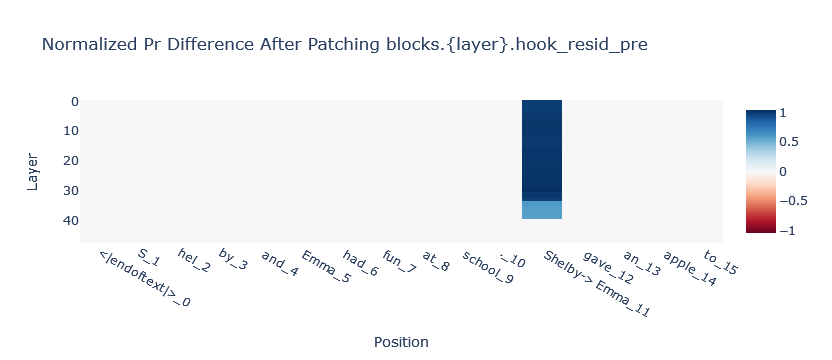

In [14]:



# useful for seeing the results of the most recent run
import plotly
name_func, hook_func = patching_types[choose_patching_type.patching_type]
hook_title = name_func(layer='{layer}', position='{pos}')
imshow(patching_result_logits, x=token_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Logit Difference After Patching {hook_title}")
imshow(patching_result_prs, x=token_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Pr Difference After Patching {hook_title}")

## Direct Logit Attribution

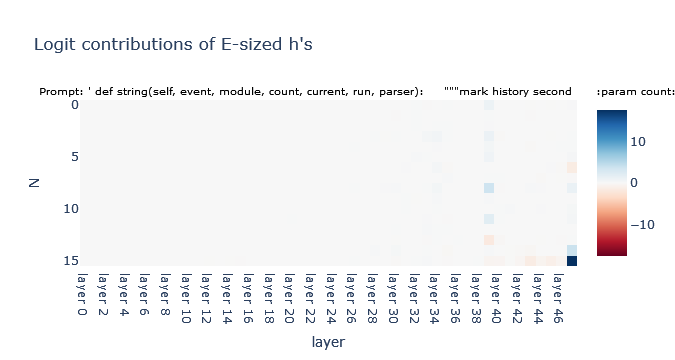

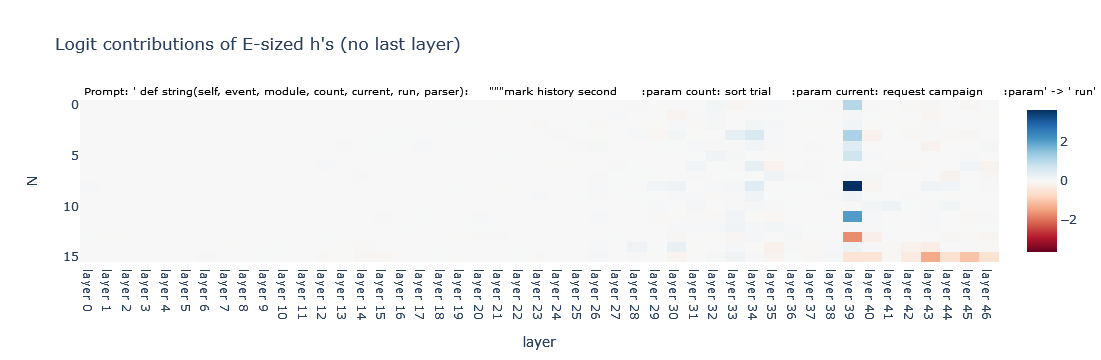

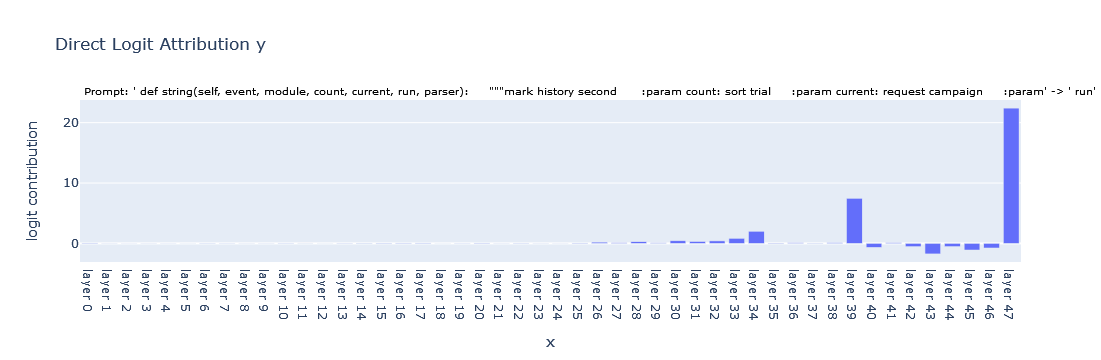

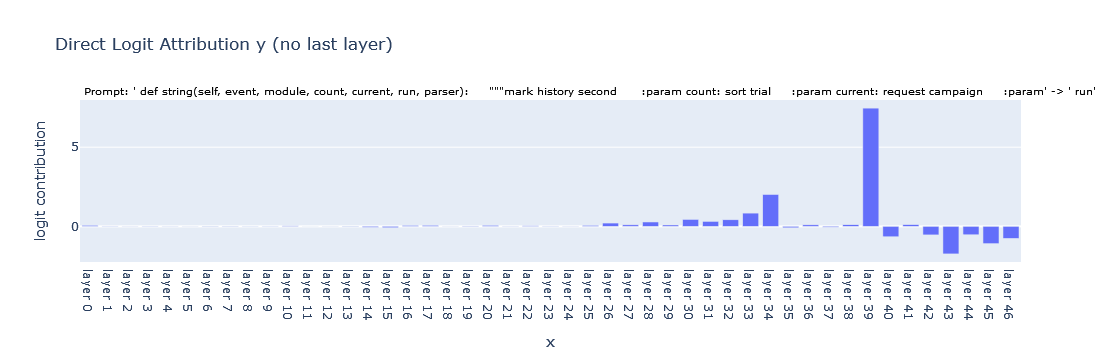

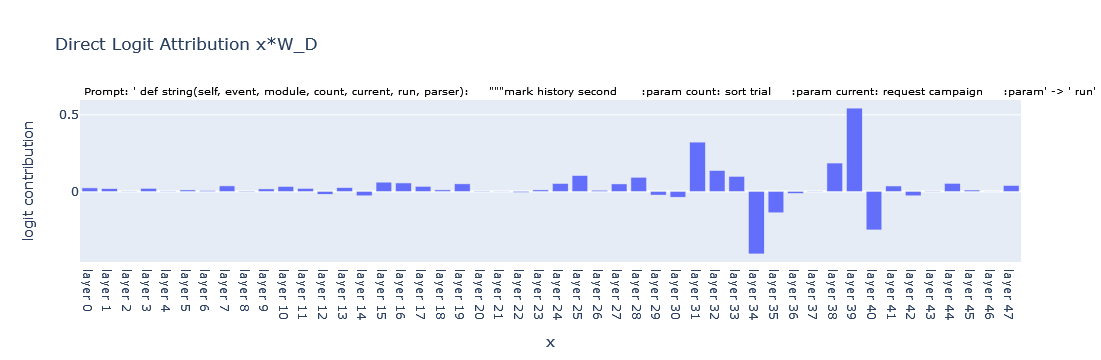

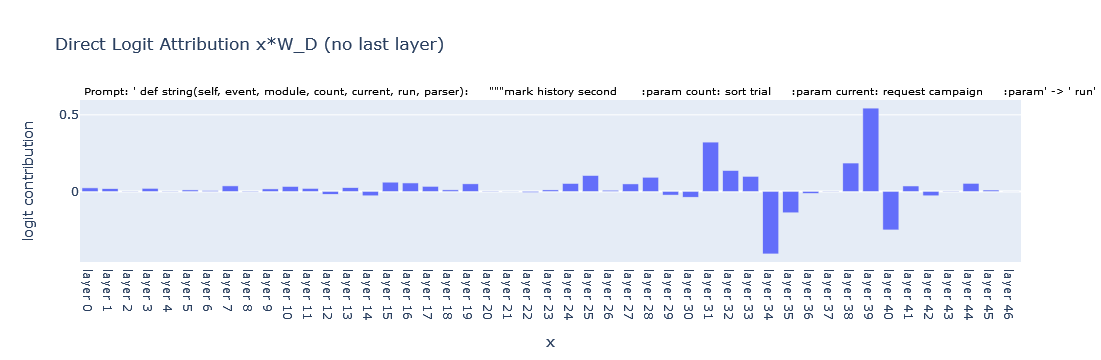

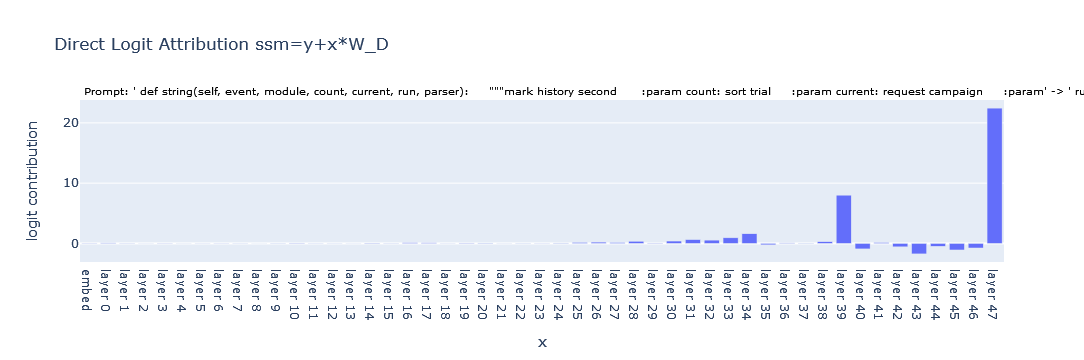

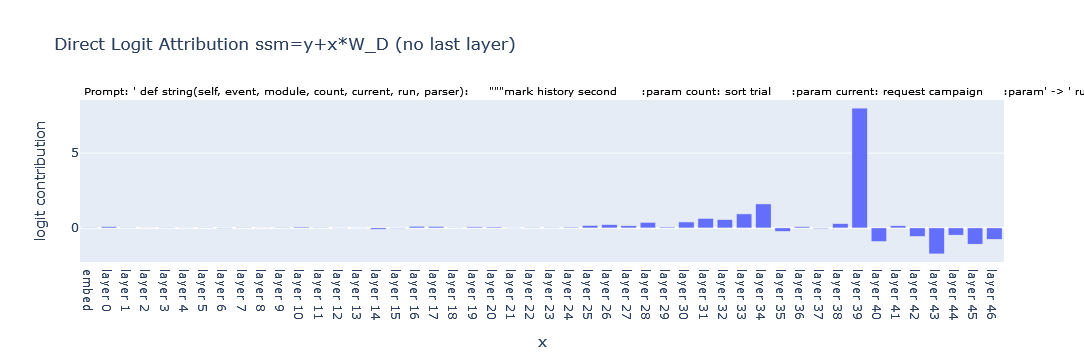

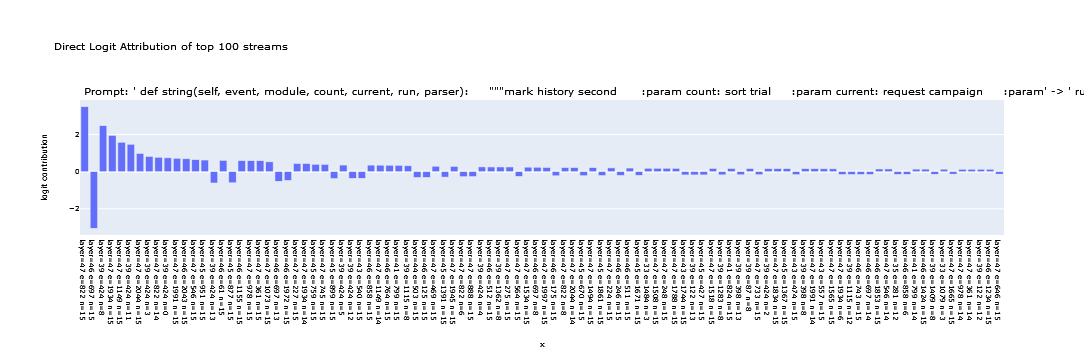

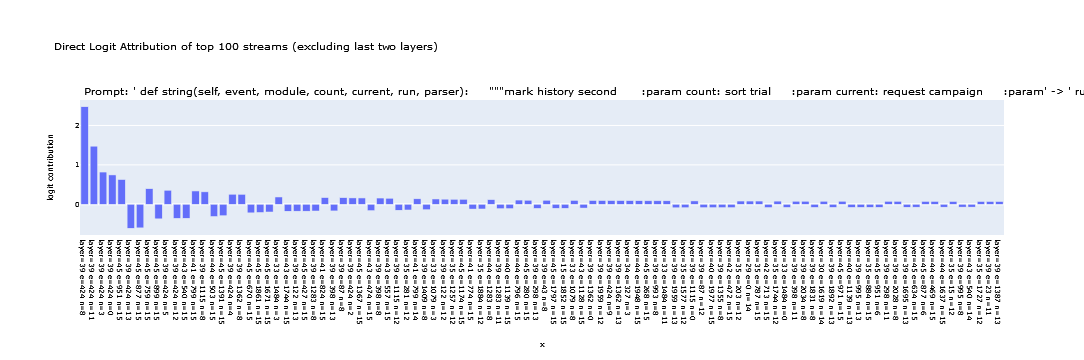

Dropdown(description='Layer', options=('layer 0', 'layer 1', 'layer 2', 'layer 3', 'layer 4', 'layer 5', 'laye…

Output()

In [49]:
import torch
import torch.nn.functional as F
import pandas as pd

import ipywidgets
from IPython.display import display, clear_output

prompt_dla = prompt_uncorrupted # defined in one of the cells above
prompt_tokens_dla = model.to_tokens(prompt_dla)
logits_dla, activations_dla = model.run_with_cache(prompt_tokens_dla)
token_labels_dla = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_dla[0]))]

prompt_answer_dla = uncorrupted_answer

target_token_dla = model.to_single_token(prompt_answer_dla)


B,L = prompt_tokens_dla.size()

D, V, E, N = model.cfg.D, model.cfg.V, model.cfg.E, model.cfg.N


# last layer after adding y_out
# [B,L,D]
resid_passed_into_norm = activations_dla[f'blocks.{model.cfg.n_layers-1}.hook_resid_post']

# norms along the d dimension
# [B,L,1]
divide_magnitudes = torch.rsqrt(resid_passed_into_norm.pow(2).mean(-1, keepdim=True)+1e-5)

# [1,1,D]
W_N = model.norm.weight.view(1,1,D)

W_unembed = model.lm_head

# [B,L,V]     [D->V]               [B,L,D]                  [B,L,1]        [1,1,D]
embed_logits = W_unembed(activations_dla[f'hook_embed'] * divide_magnitudes  *  W_N)

# [B,L,V]
res_logits_simple = embed_logits.clone()
res_logits_by_e = embed_logits.clone()

# [B,L]
res_logits_by_e_n = embed_logits.clone()[:,:,target_token_dla]

contributions_h_e = torch.zeros([model.cfg.n_layers, model.cfg.N], device=model.cfg.device)

contributions_y = torch.zeros([model.cfg.n_layers], device=model.cfg.device)

contributions_xd = torch.zeros([model.cfg.n_layers], device=model.cfg.device)

contributions_h_e_n = torch.zeros([model.cfg.n_layers, model.cfg.E, model.cfg.N], device=model.cfg.device)


for layer in range(model.cfg.n_layers):


    
    
    # [B,L,E]
    x = activations_dla[f'blocks.{layer}.hook_ssm_input']
    # [B,L,E]
    y = activations_dla[f'blocks.{layer}.hook_y']
    # [B,L,E]
    skip = F.silu(activations_dla[f'blocks.{layer}.hook_skip'])
    # [B,L,N]
    C = activations_dla[f'blocks.{layer}.hook_C']
    # [D,E]
    W_out = model.blocks[layer].out_proj

    
    
    # [B,L,E,N]
    h = torch.zeros([B,L,E,N], device=model.cfg.device)
    for l in range(L):
        # [B,E,N]
        h_l = activations_dla[f'blocks.{layer}.hook_h.{l}']
        # [B,L,E,N][:,l,:,:]   [B,E,N]
        h[:,l,:,:]             = h_l

    
    # we want to make something that does E -> V
    # this requires W_out, the norm stuff, and W_u

    # fold the norm into W_unembed
    # this doesn't include the divide_magnitudes, but those are [B,L,1] so they commute
    # its fine to just use .weight because neither of these have bias
    # [D,V]                     [D,V]          [D,1]
    W_unembed_and_norm = W_unembed.weight.T * W_N.view(D,1)
    # [E,V]                [E,D]            [D,V]
    W_unembed_from_e = W_out.weight.T @ W_unembed_and_norm

    # we can use this to do DLA of individual streams (there are ExN of them)
    # [B,L,E,N]       [B,L,E,N]         [B,L,1,N]         [B,L,E,1]                    [B,L,1,1]
    y_out           =     h       * C.view(B,L,1,N)  * skip.view(B,L,E,1) * divide_magnitudes.view(B,L,1,1)

    # we have E streams of size N
    # if we just matmul W_unembed_from_e to each E sized stream, we get V streams of size N
    # that matmul is just dot product, which is just element-wise product and then sum
    # we want the element-wise product before the sum
    # unfortunately this would be [B,L,E,N,V] which is too big for memory
    # so we will just compute the logit for our target v
    # [E]                     [E,V][:,target_token_dla]
    logit_proj_vec = W_unembed_from_e[:,target_token_dla]

    # [B,L,E,N]    [B,L,E,N]        [1,1,E,1]
    logit_contrib = y_out   *   logit_proj_vec.view(1,1,E,1)

    # [E,N]                         [B,L,E,N][0,-1]
    contributions_h_e_n[layer] = logit_contrib[0,-1]

    # [B,L]                 [B,L,E,N].sum(along E and N axis)
    stream_logit_total = logit_contrib.sum(dim=-1).sum(dim=-1)
    
    # [B,L]                   [B,L]
    res_logits_by_e_n += stream_logit_total

    # [E]
    W_D = model.blocks[layer].W_D

    y_from_c = torch.zeros([B,L,model.cfg.E], device=model.cfg.device)
    for n in range(N):
        
        # [B,L,E]       [B,L,1]                [B,L,E,N][:,:,:,n]
        y_from_c     += C[:,:,n].view(B,L,1)   *    h[:,:,:,n]

        # [B,L,V]                 [D->V]    [E->D]         [B,L,1]              [B,L,E,N][:,:,:,n]    [B,L,E]            [B,L,1]          [1,1,D]
        logit_contribution_h_e = W_unembed( W_out(    C[:,:,n].view(B,L,1)   *    h[:,:,:,n]  *         skip )       * divide_magnitudes * W_N )
        res_logits_by_e += logit_contribution_h_e
        contributions_h_e[layer,n] = logit_contribution_h_e[0,-1,target_token_dla]

    # make sure we are computing it right
    assert(torch.allclose(y, y_from_c, atol=0.01))
    

    # [B,L,V]                 [D->V]  [E->D] [B,L,E]         [B,L,E]     [B,L,1]       [1,1,D]
    logit_contribution_y  = W_unembed(W_out(    y    *        skip  )*divide_magnitudes* W_N )

    # [B,L,V]                 [D->V]  [E->D] [B,L,E]       [1,1,E]                  [B,L,E]     [B,L,1]        [1,1,D]
    logit_contribution_xd = W_unembed(W_out(    x    *  W_D.view(1,1,E)      *       skip )*divide_magnitudes * W_N)
    
    #before_add_to_resid = activations_dla[f'blocks.{layer}.hook_out_proj']
    #simple_test = W_unembed(before_add_to_resid*divide_magnitudes*W_N)

    #after_skip = activations_dla[f'blocks.{layer}.hook_after_skip']
    #simple_test = W_unembed(W_out(after_skip)*divide_magnitudes*W_N)
    contributions_y[layer] = logit_contribution_y[0,-1,target_token_dla]
    contributions_xd[layer] = logit_contribution_xd[0,-1,target_token_dla]
    
    res_logits_simple += logit_contribution_y + logit_contribution_xd
    res_logits_by_e += logit_contribution_xd # we already did the y in the loop
    # [B,L]                    [B,L,V][:,:,target_token_dla]
    res_logits_by_e_n += logit_contribution_xd[:,:,target_token_dla] # we already did the y above
    
    #res_logits += simple_test
    
# simplest W_unembed(resid_passed_into_norm*divide_magnitudes*W_N)

# make sure we did it right
assert(torch.allclose(res_logits_simple, logits_dla, atol=0.01))
assert(torch.allclose(res_logits_by_e, logits_dla, atol=0.01))
#                       [B,L]             [B,L,V][:,:,target_token_dla]
assert(torch.allclose(res_logits_by_e_n, logits_dla[:,:,target_token_dla], atol=0.01))

layer_names = ['layer ' + str(i) for i in range(model.cfg.n_layers)]

annotation = f"Prompt: '{prompt_dla}' -> '{prompt_answer_dla}'" 

ANNOTATION_FONT_SIZE = 10
def add_annotation(fig, annotation):
    fig.add_annotation(dict(font=dict(color='black',size=ANNOTATION_FONT_SIZE),
                                        x=0,
                                        y=1,
                                        showarrow=False,
                                        text=annotation,
                                        textangle=0,
                                        xanchor='left',
                                        yanchor='bottom',
                                        xref="paper",
                                        yref="paper"))

fig = px.imshow(utils.to_numpy(contributions_h_e.T), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"layer", "y":'N'}, x=layer_names, title=f"Logit contributions of E-sized h's")
add_annotation(fig, annotation=annotation)
fig.show()

fig = px.imshow(utils.to_numpy(contributions_h_e.T[:,:-1]), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"layer", "y":'N'}, x=layer_names[:-1], title=f"Logit contributions of E-sized h's (no last layer)")
add_annotation(fig, annotation=annotation)
fig.show()

def bar_chart(data, x_labels, y_label, title, annotation, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    add_annotation(fig, annotation=annotation)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()




bar_chart(data=contributions_y, x_labels=layer_names, y_label='logit contribution', title='Direct Logit Attribution y', annotation=annotation)
bar_chart(data=contributions_y[:-1], x_labels=layer_names[:-1], y_label='logit contribution', title='Direct Logit Attribution y (no last layer)', annotation=annotation)
bar_chart(data=contributions_xd, x_labels=layer_names, y_label='logit contribution', title='Direct Logit Attribution x*W_D', annotation=annotation)
bar_chart(data=contributions_xd[:-1], x_labels=layer_names[:-1], y_label='logit contribution', title='Direct Logit Attribution x*W_D (no last layer)', annotation=annotation)




# also display embed contribution here
contributions_ssm = torch.zeros([model.cfg.n_layers+1])
contributions_ssm[1:] = contributions_y + contributions_xd
contributions_ssm[0] = embed_logits[0,-1,target_token_dla]
contributions_ssm_labels = ['embed'] + layer_names
bar_chart(data=contributions_ssm, x_labels=contributions_ssm_labels, y_label='logit contribution', title='Direct Logit Attribution ssm=y+x*W_D', annotation=annotation)
bar_chart(data=contributions_ssm[:-1], x_labels=contributions_ssm_labels[:-1], y_label='logit contribution', title='Direct Logit Attribution ssm=y+x*W_D (no last layer)', annotation=annotation)



top_n = 100

def get_top_n(data, label_prefix):
    inds = torch.argsort(-torch.abs(data.flatten()))
    e_ind = inds // N
    n_ind = inds % N
    top_n_data = []
    top_n_labels = []
    only_neg = data.clone()
    only_neg[data>0] = 0
    tail_mag_neg = torch.sum(only_neg.flatten()[inds[top_n:]]).item()
    only_pos = data.clone()
    only_pos[data<0] = 0
    tail_mag_pos = torch.sum(only_pos.flatten()[inds[top_n:]]).item()
    tail_mag_total = torch.sum(torch.abs(data).flatten()[inds[top_n:]]).item()
    for i, (e, n) in enumerate(zip(e_ind[:top_n], n_ind[:top_n])):
        top_n_data.append(data[e,n].item())
        top_n_labels.append(f'{label_prefix} e={e} n={n}')
    return top_n_data, top_n_labels, (tail_mag_pos, tail_mag_neg, tail_mag_total)

def get_top_n_from_layers(data, layers):
    all_data, all_labels = [], []
    tail_mags = torch.zeros([3])
    for layer in layers:
        # this could be done simpler by flattening the whole thing but i can't be bothered to figure out how to get 3D index from that
        top_n_data, top_n_labels, mags = get_top_n(data=data[layer], label_prefix=f'layer={layer}')
        all_data += top_n_data
        all_labels += top_n_labels
        tail_mags += torch.tensor(list(mags))
        
    all_data = torch.tensor(all_data)
    tops = torch.argsort(-torch.abs(all_data))[:top_n]
    all_data = all_data[tops]
    all_labels = [all_labels[i.item()] for i in tops]
    return all_data, all_labels, tail_mags


FONT_SIZE = 7

def get_tail_mag_str(tail_mags):
    return f'  sum of streams not present +:{tail_mags[0].item()} -:{tail_mags[1].item()} all:{tail_mags[2].item()}'

all_layers_data, all_layers_labels, tail_mags = get_top_n_from_layers(data=contributions_h_e_n, layers=range(model.cfg.n_layers))
tail_mag_str = get_tail_mag_str(tail_mags)
bar_chart(data=all_layers_data, x_labels=all_layers_labels, y_label='logit contribution', title=f'Direct Logit Attribution of top {top_n} streams', annotation=annotation + tail_mag_str, font_size=FONT_SIZE)

all_layers_data, all_layers_labels, tail_mags = get_top_n_from_layers(data=contributions_h_e_n, layers=range(model.cfg.n_layers-2))
tail_mag_str = get_tail_mag_str(tail_mags)
bar_chart(data=all_layers_data, x_labels=all_layers_labels, y_label='logit contribution', title=f'Direct Logit Attribution of top {top_n} streams (excluding last two layers)', annotation=annotation + tail_mag_str, font_size=FONT_SIZE)


def display_dla(layer_ind):
    top_n = 100
    with output: # this lets the stuff we output here be visible
        clear_output()
        batch_size = N*4
        # [E,N]
        data = contributions_h_e_n[layer_ind]

        top_n_data, top_n_labels, tail_mags = get_top_n(data=data, label_prefix="")
        tail_mag_str = get_tail_mag_str(torch.tensor(list(tail_mags)))
        bar_chart(data=torch.tensor(top_n_data), x_labels=top_n_labels, y_label='logit contribution', title=f'Direct Logit Attribution of top {top_n} streams on layer {layer_ind}', annotation=annotation + tail_mag_str, font_size=FONT_SIZE)
        
        ''' show all in batches
        for start_e in range(0, E, batch_size):
            end_e = min(E, start_e + batch_size)
            # [end_e-start_e,N]
            batch_data = data[start_e:end_e,:]
            X = [str(e) for e in range(start_e, end_e)]
            fig = px.imshow(utils.to_numpy(data.T), x=X, color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"N", "y":'E'}, title=f"Logit contributions of streams at layer {layer_ind}")
            add_annotation(fig, annotation=annotation)
            fig.show()
        '''
       
choose_layer_dropdown_dla = ipywidgets.Dropdown(
    options=layer_names,
    value=layer_names[0],
    description='Layer',
) 

def choose_layer_dla(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_layer_dropdown_dla.layer = layer_names.index(change['new'])
        display_dla(layer_ind=choose_layer_dropdown_dla.layer)

choose_layer_dropdown_dla.layer = 0

choose_layer_dropdown_dla.observe(choose_layer_dla)

display(choose_layer_dropdown_dla)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)

display_dla(layer_ind=choose_layer_dropdown_dla.layer)


In [13]:
a = model.state_dict()
print(a.keys())

odict_keys(['embedding.weight', 'blocks.0.A_log', 'blocks.0.W_D', 'blocks.0.norm.weight', 'blocks.0.skip_proj.weight', 'blocks.0.in_proj.weight', 'blocks.0.conv1d.weight', 'blocks.0.conv1d.bias', 'blocks.0.W_delta_1.weight', 'blocks.0.W_delta_2.weight', 'blocks.0.W_delta_2.bias', 'blocks.0.W_B.weight', 'blocks.0.W_C.weight', 'blocks.0.out_proj.weight', 'blocks.1.A_log', 'blocks.1.W_D', 'blocks.1.norm.weight', 'blocks.1.skip_proj.weight', 'blocks.1.in_proj.weight', 'blocks.1.conv1d.weight', 'blocks.1.conv1d.bias', 'blocks.1.W_delta_1.weight', 'blocks.1.W_delta_2.weight', 'blocks.1.W_delta_2.bias', 'blocks.1.W_B.weight', 'blocks.1.W_C.weight', 'blocks.1.out_proj.weight', 'blocks.2.A_log', 'blocks.2.W_D', 'blocks.2.norm.weight', 'blocks.2.skip_proj.weight', 'blocks.2.in_proj.weight', 'blocks.2.conv1d.weight', 'blocks.2.conv1d.bias', 'blocks.2.W_delta_1.weight', 'blocks.2.W_delta_2.weight', 'blocks.2.W_delta_2.bias', 'blocks.2.W_B.weight', 'blocks.2.W_C.weight', 'blocks.2.out_proj.weight',

In [58]:


from docstring import docstring_prompt_generator_function
docstring_ind_prompt_kwargs = dict(
    n_matching_args=3, n_def_prefix_args=2, n_def_suffix_args=1, n_doc_prefix_args=0, met_desc_len=3, arg_desc_len=2
)

prompt = docstring_induction_prompt_generator("rest", **docstring_ind_prompt_kwargs, seed=seed)
print("original prompt")
print(prompt.clean_prompt)

# random_doc replaces the names in the docstring with random things (probably things not even in the definition)
# random_def replaces the names in the definition before the output name with random strs
# random_answer replaces the name in the definition with a random one

for k in prompt.corrupt_prompt.keys():
    print(k)
    print(prompt.corrupt_prompt[k])
print(prompt)


original prompt

def count(self, query, names, load, content, obj, shape):
    """middle floor payment

    :param load: bar editor
    :param content: material win
    :param
random_doc

def count(self, query, names, load, content, obj, shape):
    """middle floor payment

    :param user: bar editor
    :param context: material win
    :param
random_def

def count(self, query, names, user, context, obj, shape):
    """middle floor payment

    :param load: bar editor
    :param content: material win
    :param
random_answer

def count(self, query, names, load, content, first, shape):
    """middle floor payment

    :param load: bar editor
    :param content: material win
    :param
random_def_doc

def count(self, query, names, user, context, obj, shape):
    """middle floor payment

    :param user: bar editor
    :param context: material win
    :param
random_answer_doc

def count(self, query, names, load, content, first, shape):
    """middle floor payment

    :param user: bar ed

In [16]:
torch.linalg.norm(torch.tensor([1,2.0]), ord=2)

tensor(2.2361)

### Train SAE

In [1]:
# modified code from https://github.com/jbloomAus/mats_sae_training

import torch
torch.set_grad_enabled(True)
import os
import sys
sys.path.append(os.getcwd() + "/mats_sae_training")

In [2]:
import mats_sae_training.sae_training.config
cfg = mats_sae_training.sae_training.config.LanguageModelSAERunnerConfig(
    # Data Generating Function (Model + Training Distibuion)
    model_name = "state-spaces/mamba-370m",
    hook_point = "blocks.39.hook_ssm_input",
    hook_point_layer = 39,
    hook_point_eval = 'blocks.39.hook_ssm_output', # we compare this when replace hook_point activations with autoencode.decode(autoencoder.encode( hook_point activations))
    d_in = 2048,
    dataset_path = "Skylion007/openwebtext",
    is_dataset_tokenized=False,
    
    # SAE Parameters
    expansion_factor = 8,# 64,
    b_dec_init_method = "geometric_median",
    
    # Training Parameters
    lr = 0.0004,
    l1_coefficient = 0.00006*0.2, # the sae expert said to decrease this 
    lr_scheduler_name="constantwithwarmup",
    train_batch_size = 4096,
    context_size = 128,
    lr_warm_up_steps=5000,
    
    # Activation Store Parameters
    n_batches_in_buffer = 128,
    total_training_tokens = 1_000_000 * 300,
    store_batch_size = 32,
    
    # Dead Neurons and Sparsity
    use_ghost_grads=True,
    #feature_sampling_method = None,
    feature_sampling_window = 1000,
    dead_feature_window=5000,
    dead_feature_threshold = 1e-6,
    
    # WANDB
    log_to_wandb = True,
    wandb_project= "mats_sae_training_mamba",
    wandb_entity = None,
    wandb_log_frequency=100,
    
    # Misc
    device = "cuda",
    seed = 42,
    n_checkpoints = 10,
    checkpoint_path = "checkpoints",
    dtype = torch.float32,
)


Run name: 16384-L1-1.2e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06


In [3]:
from mats_sae_training.sae_training.lm_runner import language_model_sae_runner
language_model_sae_runner(cfg)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda
Moving model to device:  cuda


/home/dev/.local/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset is not tokenized! Updating config.


wandb: Currently logged in as: phylliidadev. Use `wandb login --relogin` to force relogin


Objective value: 11.5179:  15%|████████▍                                               | 15/100 [01:36<09:08,  6.46s/it]


Reinitializing b_dec with geometric median of activations
Previous distances: 13.737929344177246
New distances: 11.263940811157227


/home/dev/mamba_interp/mats_sae_training/sae_training/sparse_autoencoder.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out, dtype=self.dtype, device=self.device)
7324| MSE Loss 0.001 | L1 0.001:  10%|███                           | 30003200/300000000 [1:19:11<2:25:35, 30909.45it/s]

Saved model to checkpoints/tpeawkye/30003200_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


14648| MSE Loss 0.000 | L1 0.001:  20%|█████▊                       | 59998208/300000000 [2:40:30<1:34:49, 42185.11it/s]

Saved model to checkpoints/tpeawkye/60002304_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


21972| MSE Loss 0.000 | L1 0.001:  30%|████████▋                    | 90001408/300000000 [4:01:34<3:38:53, 15989.77it/s]

Saved model to checkpoints/tpeawkye/90001408_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


29296| MSE Loss 0.000 | L1 0.001:  40%|███████████▏                | 120000512/300000000 [5:21:51<1:11:29, 41967.29it/s]

Saved model to checkpoints/tpeawkye/120000512_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


36621| MSE Loss 0.000 | L1 0.001:  50%|██████████████▍              | 149999616/300000000 [6:42:14<7:43:05, 5398.57it/s]

Saved model to checkpoints/tpeawkye/150003712_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


43945| MSE Loss 0.000 | L1 0.001:  60%|█████████████████▉            | 179998720/300000000 [8:03:16<49:19, 40543.59it/s]

Saved model to checkpoints/tpeawkye/180002816_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


51269| MSE Loss 0.000 | L1 0.001:  70%|███████████████████▌        | 209997824/300000000 [9:25:00<16:59:09, 1471.83it/s]

Saved model to checkpoints/tpeawkye/210001920_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


58593| MSE Loss 0.000 | L1 0.001:  80%|███████████████████████▏     | 239996928/300000000 [10:44:42<28:07, 35550.67it/s]

Saved model to checkpoints/tpeawkye/240001024_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


65917| MSE Loss 0.000 | L1 0.001:  90%|██████████████████████████   | 270000128/300000000 [12:06:37<11:52, 42104.78it/s]

Saved model to checkpoints/tpeawkye/270000128_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


73242| MSE Loss 0.000 | L1 0.001: : 300003328it [13:28:43, 27315.77it/s]                                                

Saved model to checkpoints/tpeawkye/final_sparse_autoencoder_state-spaces_mamba-370m_blocks.39.hook_ssm_input_16384.pt


73242| MSE Loss 0.000 | L1 0.001: : 300003328it [13:28:47, 6182.10it/s] 


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


  0%|          | 0/48 [00:00<?, ?it/s]

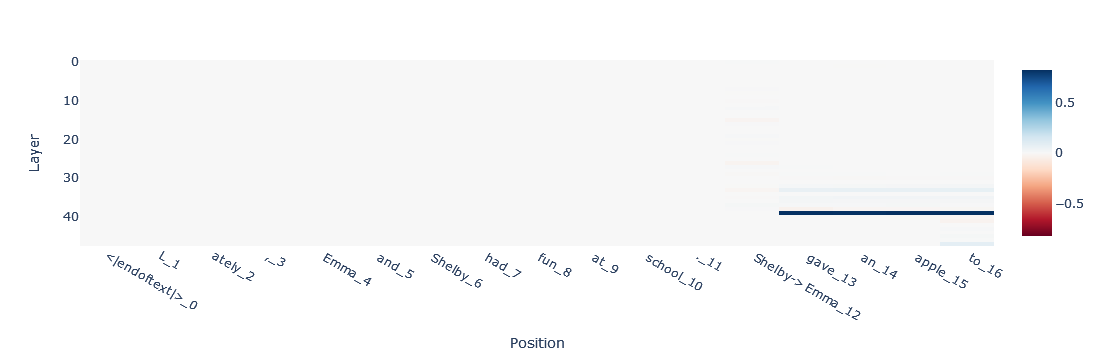

In [9]:
from tqdm.notebook import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
import torch
import plotly.express as px

import hooked_mamba
model = hooked_mamba.HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')

prompt_uncorrupted = 'Lately, Emma and Shelby had fun at school. Shelby gave an apple to'
prompt_corrupted = 'Lately, Emma and Shelby had fun at school. Emma gave an apple to'
uncorrupted_answer = ' Emma' # note the space in front is important
corrupted_answer = ' Shelby'

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)

# 'blocks.{layer}.hook_h.{pos}' is the recurrent state of that layer after processing tokens at and before pos position
def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    layer: int,
    position: int,
) -> Float[torch.Tensor, "B E N"]:
    return corrupted_activations[hook.name]
    
patching_result_logits = torch.zeros((model.cfg.n_layers, L), device=model.cfg.device)
for layer in tqdm(range(model.cfg.n_layers)):
    for position in range(L):
        patching_hook_name = f'blocks.{layer}.hook_h.{position}'
        patching_hook = partial(h_patching_hook, layer=layer, position=position)
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=[
            (patching_hook_name, patching_hook)
        ])
        
        patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits,
                                                                     uncorrupted_answer=uncorrupted_answer,
                                                                     corrupted_answer=corrupted_answer)
        # normalize it so
        # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
        # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
        normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
        # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
        # so now
        # 0 means that it is acting like the uncorrupted model
        # 1 means that it is acting like the corrupted model
        normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
        patching_result_logits[layer, position] = normalized_patched_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

# display outputs
px.imshow(utils.to_numpy(patching_result_logits), x=token_labels, color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"Position", "y":"Layer"}).show()


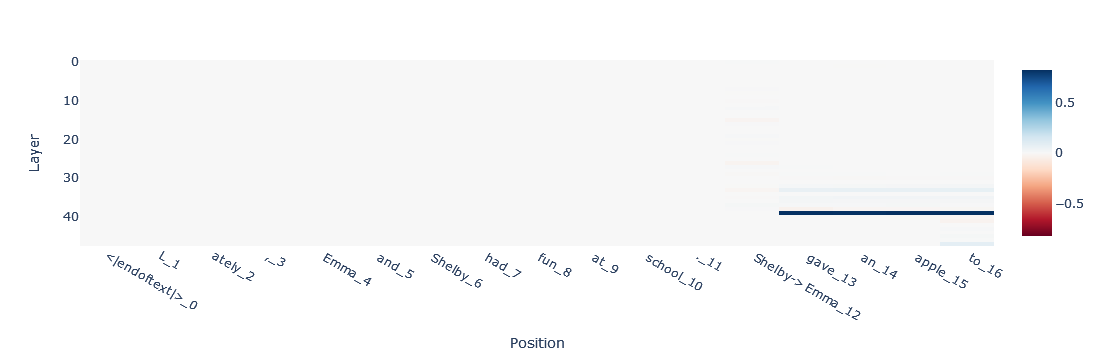

In [8]:


px.imshow(utils.to_numpy(patching_result_logits), x=token_labels, color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"Position", "y":"Layer"}).show()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


  0%|          | 0/48 [00:00<?, ?it/s]

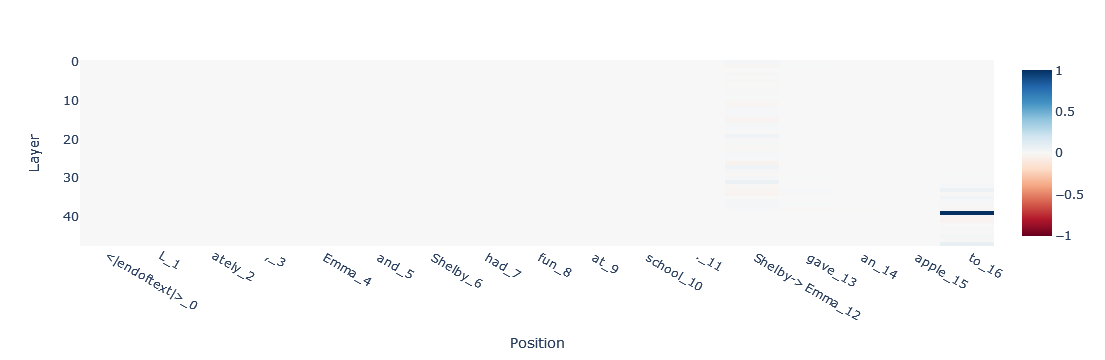

In [10]:
from tqdm.notebook import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
import torch
import plotly.express as px

import hooked_mamba
model = hooked_mamba.HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')

prompt_uncorrupted = 'Lately, Emma and Shelby had fun at school. Shelby gave an apple to'
prompt_corrupted = 'Lately, Emma and Shelby had fun at school. Emma gave an apple to'
uncorrupted_answer = ' Emma' # note the space in front is important
corrupted_answer = ' Shelby'

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)

# 'blocks.{layer}.hook_h.{pos}' is the recurrent state of that layer after processing tokens at and before pos position
def ssm_output_patching_hook(
    ssm_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_ssm_output = corrupted_activations[hook.name]
    ssm_output[:, position, :] = corrupted_ssm_output[:, position, :]
    return ssm_output
    
patching_result_logits = torch.zeros((model.cfg.n_layers, L), device=model.cfg.device)
for layer in tqdm(range(model.cfg.n_layers)):
    for position in range(L):
        patching_hook_name = f'blocks.{layer}.hook_ssm_output'
        patching_hook = partial(ssm_output_patching_hook, layer=layer, position=position)
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=[
            (patching_hook_name, patching_hook)
        ])
        
        patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits,
                                                                     uncorrupted_answer=uncorrupted_answer,
                                                                     corrupted_answer=corrupted_answer)
        # normalize it so
        # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
        # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
        normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
        # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
        # so now
        # 0 means that it is acting like the uncorrupted model
        # 1 means that it is acting like the corrupted model
        normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
        patching_result_logits[layer, position] = normalized_patched_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

# display outputs
px.imshow(utils.to_numpy(patching_result_logits), x=token_labels, color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"Position", "y":"Layer"}).show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


  0%|          | 0/48 [00:00<?, ?it/s]

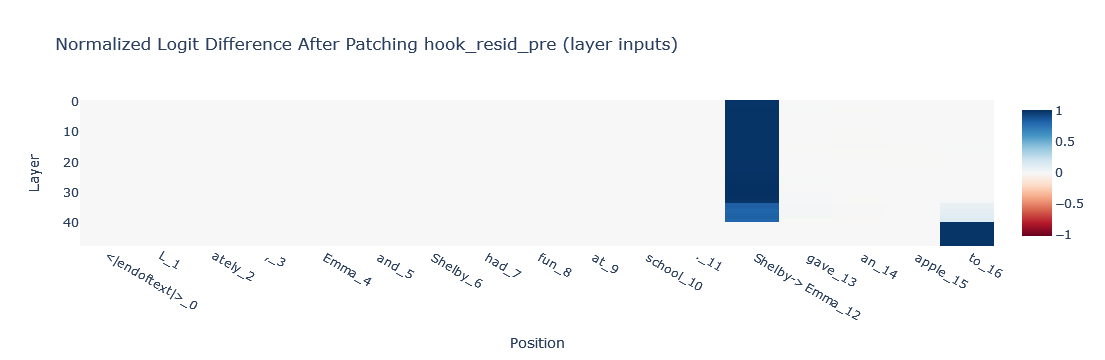

In [15]:
from tqdm.notebook import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
import torch
import plotly.express as px

import hooked_mamba
model = hooked_mamba.HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')

prompt_uncorrupted = 'Lately, Emma and Shelby had fun at school. Shelby gave an apple to'
prompt_corrupted = 'Lately, Emma and Shelby had fun at school. Emma gave an apple to'
uncorrupted_answer = ' Emma' # note the space in front is important
corrupted_answer = ' Shelby'

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)

token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

# 'blocks.{layer}.resid_pre' is the input to layer {layer}
def resid_pre_patching_hook(
    resid_pre: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_resid_pre = corrupted_activations[hook.name]
    resid_pre[:, position, :] = corrupted_resid_pre[:, position, :]
    return resid_pre
    
patching_result_logits = torch.zeros((model.cfg.n_layers, L), device=model.cfg.device)
for layer in tqdm(range(model.cfg.n_layers)):
    for position in range(L):
        patching_hook_name = f'blocks.{layer}.hook_resid_pre'
        patching_hook = partial(resid_pre_patching_hook, layer=layer, position=position)
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=[
            (patching_hook_name, patching_hook)
        ], fast_ssm=True, fast_conv=True)
        
        patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits,
                                                                     uncorrupted_answer=uncorrupted_answer,
                                                                     corrupted_answer=corrupted_answer)
        # normalize it so
        # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
        # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
        normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
        # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
        # so now
        # 0 means that it is acting like the uncorrupted model
        # 1 means that it is acting like the corrupted model
        normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
        patching_result_logits[layer, position] = normalized_patched_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

# display outputs
px.imshow(utils.to_numpy(patching_result_logits), x=token_labels, color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"Position", "y":"Layer"}, title='Normalized Logit Difference After Patching hook_resid_pre (layer inputs)').show()

In [16]:
from tqdm.notebook import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
import torch
import plotly.express as px

import hooked_mamba
model = hooked_mamba.HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')

prompt_uncorrupted = 'Lately, Emma and Shelby had fun at school. Shelby gave an apple to'
prompt_corrupted = 'Lately, Emma and Shelby had fun at school. Emma gave an apple to'
uncorrupted_answer = ' Emma' # note the space in front is important
corrupted_answer = ' Shelby'

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)

# 'blocks.{layer}.hook_h.{pos}' is the recurrent state of that layer after processing tokens at and before pos position
def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    layer: int,
    position: int,
) -> Float[torch.Tensor, "B E N"]:
    return corrupted_activations[hook.name]
    
patching_result_logits = torch.zeros((model.cfg.n_layers, L), device=model.cfg.device)
for layer in tqdm(range(model.cfg.n_layers)):
    for position in range(L):
        patching_hook_name = f'blocks.{layer}.hook_h.{position}'
        patching_hook = partial(h_patching_hook, layer=layer, position=position)
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=[
            (patching_hook_name, patching_hook)
        ])
        
        patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits,
                                                                     uncorrupted_answer=uncorrupted_answer,
                                                                     corrupted_answer=corrupted_answer)
        # normalize it so
        # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
        # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
        normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
        # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
        # so now
        # 0 means that it is acting like the uncorrupted model
        # 1 means that it is acting like the corrupted model
        normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
        patching_result_logits[layer, position] = normalized_patched_logit_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

# display outputs
px.imshow(utils.to_numpy(patching_result_logits), x=token_labels, color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"Position", "y":"Layer"}, title='Normalized Logit Difference After Patching hook_h (hidden state)').show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


  0%|          | 0/48 [00:00<?, ?it/s]

In [67]:
torch.concatenate([torch.randn([5,7]), torch.randn([5,6])], dim=1).size()

torch.Size([5, 13])

In [1]:
from importlib import reload
from mamba_lens import HookedMamba
model = HookedMamba.from_pretrained("state-spaces/mamba-370m")

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [82]:

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)
    

def eval(model, data, correct, incorrect, **kwargs):
        num_examples = correct.size()[0]
        logits = model(data, **kwargs)[:,-1]
        tops = torch.argsort(-logits, dim=1)
        prs = torch.nn.functional.softmax(logits, dim=1)
        pad = model.tokenizer.encode(model.tokenizer.pad_token)
        prs[:,pad] = 0 # manually set pad pr to zero because sometimes we need to pad num correct or num incorrect
        #for i in range(tops.size()[0]):
        #    print(model.to_str_tokens([tops[i,0]]), tops[i,0], logits[i, tops[i,0]], prs[i, tops[i,0]])
        #    break
        # [n_data, n_correct]
        correct_prs = index_into(prs, correct)
        # [n_data, n_incorrect]
        incorrect_prs = index_into(prs, incorrect)
        # [n_data, 1]
        total_prs = correct_prs.sum(dim=1, keepdim=True)+incorrect_prs.sum(dim=1, keepdim=True)
        total_prs[total_prs == 0] = 1.0
        correct_prs /= total_prs
        incorrect_prs /= total_prs

        # [n_data, n_correct + n_incorrect]
        combined = torch.concatenate([correct_prs, incorrect_prs], dim=1)
        biggest = torch.argsort(-combined, dim=1)
        n_data, n_correct = correct.size()
        # if biggest pr is in the correct, we are correct, otherwise, we are not
        num_correct = torch.sum(biggest[:,0] < n_correct)
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs.sum(dim=1)).item(), torch.mean(incorrect_prs.sum(dim=1)).item(), num_correct.item()/float(n_data)

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 3:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(batched_correct)
        batched_incorrect = torch.tensor(batched_incorrect)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

In [52]:
def test_index_into():
    logits = torch.randn([5,2292])
    indices = [[1,2],[2,5],[3,55],[4,2242],[1,11]]
    print(index_into(logits, torch.tensor(indices, dtype=torch.long)))
    for row in range(len(indices)):
        print()
        for i in indices[row]:
            print(logits[row, i].item(), end=",")
    

tensor([[-0.6721, -0.2399],
        [-1.1438,  0.9626],
        [-0.7719,  2.2192],
        [ 0.9742,  0.1376],
        [ 0.5076,  0.0848]])

-0.6720613241195679,-0.23987716436386108,
-1.143798589706421,0.9626398086547852,
-0.7719347476959229,2.2192084789276123,
0.9742070436477661,0.13760212063789368,
0.5076157450675964,0.08476564288139343,

In [84]:

from einops import rearrange
import torch
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint


torch.set_grad_enabled(False)
input = "hello world how are you"

def top_p_logits(logits):
    logits = logits[0,-1]
    prs = torch.nn.functional.softmax(logits, dim=0)
    top_n = torch.argsort(-prs)
    for i in top_n[:5]:
        print(model.to_str_tokens([i]), prs[i].item(), logits[i].item())
    

class EmptyObject:
    pass

in_proj_storage = EmptyObject()
in_proj_storage.in_proj = None

def in_proj_hook(
    in_proj: Float[torch.Tensor, "B L E"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E"]:
    setattr(in_proj_storage, "in_proj", in_proj)
    return in_proj

def ignore_conv_hook(
    x_conv: Float[torch.Tensor, "B L E"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E"]:
    return in_proj_storage.in_proj


ignore_conv_hooks = []
for layer in range(model.cfg.n_layers):
    ignore_conv_hooks.append((f"blocks.{layer}.hook_in_proj", in_proj_hook))
    ignore_conv_hooks.append((f"blocks.{layer}.hook_conv", ignore_conv_hook))


baseline_logits = model.run_with_hooks(input)

no_conv_logits = model.run_with_hooks(input, fwd_hooks=ignore_conv_hooks)

#print(baseline_logits)
#print(top_p_logits(baseline_logits))
#print(no_conv_logits)
#print(top_p_logits(no_conv_logits))

D_CONV = model.cfg.d_conv

def mostly_ignore_conv_hook(
    x_conv: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:

    conv_input = in_proj_storage.in_proj
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')

    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    for i in range(D_CONV):
        #                 [E]                    [B,E,L]
        #output += conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L] # this is what conv is doing
        output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input
    
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output

from functools import partial

mostly_ignore_conv_hooks = []
for layer in range(model.cfg.n_layers):
    mostly_ignore_conv_hooks.append((f"blocks.{layer}.hook_in_proj", in_proj_hook))
    mostly_ignore_conv_hooks.append((f"blocks.{layer}.hook_conv", partial(mostly_ignore_conv_hook, layer=layer)))
    

mostly_ignore_conv_logits = model.run_with_hooks(input, fwd_hooks=mostly_ignore_conv_hooks)

#print(mostly_ignore_conv_logits)
#print(top_p_logits(mostly_ignore_conv_logits))



from test_data import greater_than_data_generator, IOI_generator, ABC_TEMPLATES, BAC_TEMPLATES, BABA_TEMPLATES, BABA_LONG_TEMPLATES, BABA_LATE_IOS, BABA_EARLY_IOS

from importlib import reload
import test_data
reload(test_data)

TEMPLATES = [
    ("ABC", ABC_TEMPLATES),
    ("BAC", BAC_TEMPLATES),
    ("BABA", BABA_TEMPLATES),
    ("BABA_LONG", BABA_LONG_TEMPLATES),
    ("BABA_LATE", BABA_LATE_IOS),
    ("BABA_EARLY", BABA_EARLY_IOS)
]

ALL_TEMPLATES = []
for (n, t) in TEMPLATES:
    ALL_TEMPLATES += t


seed = 27

def model_wrapper(input):
    return model.run_with_hooks(input, fwd_hooks=mostly_ignore_conv_hooks)

num_examples = 30

from test_data import test_data, print_data
#outputs = test_data(data_generator=IOI_generator, templates=ALL_TEMPLATES,  model=model_wrapper, tokenizer=model.tokenizer, num_examples=num_examples, top_n=1, constrain=True, debug=False)

#print_data(*outputs)



ssm_inputs_storage = EmptyObject()


def ssm_input_hook(
    ssm_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    ssm_inputs_storage.ssm_input = ssm_input
    return ssm_input

def C_hook(
    C: Float[torch.Tensor, "B L N"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L N"]:
    ssm_inputs_storage.C = C
    return C

def B_bar_hook(
    B_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E N"]:
    ssm_inputs_storage.B_bar = B_bar
    return B_bar

def ssm_output_hook(
    ssm_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    # return ssm_output
    # [B,L,E]
    x = ssm_inputs_storage.ssm_input
    B,L,E = x.size()
    # [B,L,N]
    C = ssm_inputs_storage.C
    B,L,N = C.size()
    # [B,L,E,N]
    B_bar = ssm_inputs_storage.B_bar
    output = torch.zeros((B,L,E), device=model.cfg.device)
    for n in range(N):
        #  [B,L,E]             [B,L,E]        [B,L,E]
        h_contributions =   B_bar[:,:,:,n]   *   x
        #[B,L,E]    [B,L,E]               [B,L,1]
        output   +=  h_contributions *  C[:,:,n].view(B,L,1)
        
    #     [B,L,E]         [B,L,E]           [E]
    return   output     +   x    *  model.blocks[layer].W_D




ignore_ssm_hooks = []
for layer in range(model.cfg.n_layers):
    ignore_ssm_hooks.append((f"blocks.{layer}.hook_ssm_input", partial(ssm_input_hook, layer=layer)))
    ignore_ssm_hooks.append((f"blocks.{layer}.hook_C", C_hook))
    ignore_ssm_hooks.append((f"blocks.{layer}.hook_B_bar", B_bar_hook))
    ignore_ssm_hooks.append((f"blocks.{layer}.hook_ssm_output", partial(ssm_output_hook, layer=layer)))
    
accuracies = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs_incorrect = torch.zeros([model.cfg.n_layers], device=model.cfg.device)


num_examples = 100

seed = 27
valid_seed = 37

from docstring import docstring_prompt_generator_function, docstring_induction_prompt_generator

data_type = 'docstring'
if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[0]], tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[0]], tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)

print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("valid")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)

#print(batched_data.size(), batched_correct.size(), batched_incorrect.size())


#print(eval(model_wrapper, batched_data, batched_correct, batched_incorrect))


import tqdm

best_layer = None

history = []
history_stats = []
layers_to_remove = []
while len(layers_to_remove) < model.cfg.n_layers:
    base_layers = list(range(model.cfg.n_layers))


    for layer in layers_to_remove:
        base_layers.remove(layer)
    history.append(list(base_layers))
    
    correct, incorrect, acc = eval(model, vbatched_data, vbatched_correct, vbatched_incorrect,
                                      only_use_these_layers=base_layers, fast_ssm=True, fast_conv=True)
    print(correct, incorrect, acc)
    history_stats.append((correct, incorrect, acc))
    print(base_layers)
    
    for i, start_layer in tqdm.tqdm(enumerate(base_layers)):
        #layers = list(range(start_layer, end_layer+1))
        layers = list(base_layers)
        layers.remove(start_layer)

        
        correct, incorrect, acc = eval(model, batched_data, batched_correct, batched_incorrect,
                                      only_use_these_layers=layers, fast_ssm=True, fast_conv=True)
        accuracies[i] = acc
        out_prs[i] = correct
        out_prs_incorrect[i] = incorrect
        
    
    best_layer_to_remove = base_layers[torch.argsort(-accuracies[:len(base_layers)])[0]]
    print("removing layer", best_layer_to_remove)
    layer_names = [f'layer {x}' for x in base_layers]
    layers_to_remove.append(best_layer_to_remove)

history_stats = torch.tensor(history_stats)


'''
        def model_wrapper_ignore_ssm(input):
            #return model.run_with_hooks(input, fwd_hooks=ignore_ssm_hooks)


        
        seed = 27
        outputs = test_data(data_generator=IOI_generator, templates=ALL_TEMPLATES,  model=model_wrapper_ignore_ssm, tokenizer=model.tokenizer, num_examples=num_examples, top_n=1, constrain=True, debug=False)
        
        #print_data(*outputs)
        num_correct = outputs[0][0]
        accuracy = num_correct / float(num_examples)
        print(accuracy)
        accuracies[start_layer, end_layer] = accuracy


'''

#px.imshow(utils.to_numpy(out_prs), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"", "y":""}, title="IOI pr of correct token, row i column j means we include layers [i,...,j]").show()
#px.imshow(utils.to_numpy(out_prs_incorrect), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":"", "y":""}, title="IOI pr of incorrect token, row i column j means we include layers [i,...,j]").show()

#bar_chart(accuracies[:,0], x_labels=[f'layer {x}' for x in range(0, model.cfg.n_layers)], y_label='pr', title="IOI accuracy, removing a specific layer", font_size=9)
#bar_chart(out_prs[:,0], x_labels=[f'layer {x}' for x in range(0, model.cfg.n_layers)], y_label='pr', title="IOI pr of correct token, removing a specific layer", font_size=9)
#bar_chart(out_prs_incorrect[:,0], x_labels=[f'layer {x}' for x in range(0, model.cfg.n_layers)], y_label='pr', title="IOI pr of incorrect token, removing a specific layer", font_size=9)

data

def string(self, event, module, count, current, run, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param [' run'] [' start', ' row', ' response', ' form', ' index', ' query', ' resource', ' output', ' count', ' current', ' event', ' module', ' parser']

def string(self, event, module, count, current, start, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param [' start'] [' row', ' response', ' form', ' index', ' query', ' resource', ' output', ' count', ' current', ' event', ' module', ' parser', ' run']

def instance(self, shape, context, code, index, result, names):
    """faith data screen

    :param code: sum item
    :param index: stock section
    :param [' result'] [' parser', ' old', ' date', ' default', ' size', ' settings', ' status', ' found', ' code', ' index', ' shape', ' context', ' names']
valid

def required(self, module, text, token, event, 

48it [00:19,  2.50it/s]


removing layer 5
0.7768911719322205 0.22310878336429596 0.96
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


47it [00:18,  2.54it/s]


removing layer 15
0.7830162048339844 0.21698372066020966 0.94
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


46it [00:17,  2.58it/s]


removing layer 4
0.7788031101226807 0.2211969643831253 0.93
[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


45it [00:17,  2.63it/s]


removing layer 6
0.7808526158332825 0.21914741396903992 0.95
[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


44it [00:16,  2.68it/s]


removing layer 2
0.7858405709266663 0.21415942907333374 0.96
[0, 1, 3, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


43it [00:15,  2.74it/s]


removing layer 3
0.7794155478477478 0.22058434784412384 0.95
[0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


42it [00:15,  2.80it/s]


removing layer 7
0.7837527990341187 0.21624717116355896 0.95
[0, 1, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


41it [00:14,  2.86it/s]


removing layer 10
0.8104720711708069 0.18952788412570953 0.97
[0, 1, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


40it [00:13,  2.93it/s]


removing layer 8
0.7796980738639832 0.22030183672904968 0.94
[0, 1, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


39it [00:13,  3.00it/s]


removing layer 11
0.8686520457267761 0.13134795427322388 0.98
[0, 1, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


38it [00:12,  3.07it/s]


removing layer 9
0.8658785223960876 0.13412149250507355 0.97
[0, 1, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


37it [00:11,  3.15it/s]


removing layer 1
0.8559023141860962 0.14409767091274261 0.98
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


36it [00:11,  3.23it/s]


removing layer 26
0.8020298480987549 0.19797004759311676 0.94
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


35it [00:10,  3.31it/s]


removing layer 39
0.9111644625663757 0.08883554488420486 0.97
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47]


34it [00:09,  3.41it/s]


removing layer 38
0.9059002995491028 0.09409960359334946 0.96
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47]


33it [00:09,  3.50it/s]


removing layer 36
0.890356719493866 0.10964322835206985 0.96
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 41, 42, 43, 44, 45, 46, 47]


32it [00:08,  3.59it/s]


removing layer 47
0.9159667491912842 0.08403326570987701 0.94
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 41, 42, 43, 44, 45, 46]


31it [00:08,  3.70it/s]


removing layer 42
0.9149267077445984 0.08507326245307922 0.94
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 41, 43, 44, 45, 46]


30it [00:07,  3.82it/s]


removing layer 46
0.8904932141304016 0.1095067635178566 0.93
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 41, 43, 44, 45]


29it [00:07,  3.94it/s]


removing layer 43
0.8879507184028625 0.11204921454191208 0.92
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 41, 44, 45]


28it [00:06,  4.07it/s]


removing layer 37
0.8729434609413147 0.12705647945404053 0.92
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 44, 45]


27it [00:06,  4.21it/s]


removing layer 44
0.8513140678405762 0.14868593215942383 0.87
[0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 45]


26it [00:05,  4.34it/s]


removing layer 20
0.8342440128326416 0.1657560169696808 0.86
[0, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 45]


25it [00:05,  4.51it/s]


removing layer 24
0.7534574866294861 0.24654249846935272 0.78
[0, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 45]


24it [00:05,  4.68it/s]


removing layer 21
0.7441712617874146 0.25582873821258545 0.81
[0, 12, 13, 14, 16, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 45]


23it [00:04,  4.86it/s]


removing layer 14
0.6507856845855713 0.3492143154144287 0.66
[0, 12, 13, 16, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 45]


22it [00:04,  5.05it/s]


removing layer 35
0.6051758527755737 0.3948240876197815 0.68
[0, 12, 13, 16, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 40, 41, 45]


21it [00:03,  5.26it/s]


removing layer 16
0.5627074837684631 0.43729251623153687 0.57
[0, 12, 13, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 40, 41, 45]


20it [00:03,  5.49it/s]


removing layer 45
0.37715864181518555 0.6228412985801697 0.39
[0, 12, 13, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 40, 41]


19it [00:03,  5.73it/s]


removing layer 41
0.4034850299358368 0.5965149402618408 0.41
[0, 12, 13, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 40]


18it [00:02,  6.01it/s]


removing layer 40
0.45355066657066345 0.5464493632316589 0.46
[0, 12, 13, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34]


17it [00:02,  6.32it/s]


removing layer 31
0.3020351231098175 0.6979648470878601 0.31
[0, 12, 13, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 32, 33, 34]


16it [00:02,  6.66it/s]


removing layer 27
0.43109050393104553 0.5689094662666321 0.43
[0, 12, 13, 17, 18, 19, 22, 23, 25, 28, 29, 30, 32, 33, 34]


15it [00:02,  7.00it/s]


removing layer 29
0.46452054381370544 0.5354794263839722 0.46
[0, 12, 13, 17, 18, 19, 22, 23, 25, 28, 30, 32, 33, 34]


14it [00:01,  7.45it/s]


removing layer 32
0.3181016147136688 0.6818983554840088 0.32
[0, 12, 13, 17, 18, 19, 22, 23, 25, 28, 30, 33, 34]


13it [00:01,  7.93it/s]


removing layer 30
0.18020622432231903 0.8197937607765198 0.18
[0, 12, 13, 17, 18, 19, 22, 23, 25, 28, 33, 34]


12it [00:01,  8.42it/s]


removing layer 34
0.052928950637578964 0.9470710754394531 0.05
[0, 12, 13, 17, 18, 19, 22, 23, 25, 28, 33]


11it [00:01,  9.08it/s]


removing layer 22
0.05906112492084503 0.9409388303756714 0.05
[0, 12, 13, 17, 18, 19, 23, 25, 28, 33]


10it [00:01,  9.86it/s]


removing layer 18
0.0653059333562851 0.9346940517425537 0.07
[0, 12, 13, 17, 19, 23, 25, 28, 33]


9it [00:00, 10.65it/s]


removing layer 23
0.061196718364953995 0.9388033151626587 0.06
[0, 12, 13, 17, 19, 25, 28, 33]


8it [00:00, 11.54it/s]


removing layer 28
0.06725773960351944 0.9327422976493835 0.06
[0, 12, 13, 17, 19, 25, 33]


7it [00:00, 12.81it/s]


removing layer 19
0.08737418800592422 0.912625789642334 0.09
[0, 12, 13, 17, 25, 33]


6it [00:00, 14.16it/s]


removing layer 12
0.08242985606193542 0.917570173740387 0.09
[0, 13, 17, 25, 33]


5it [00:00, 16.25it/s]


removing layer 33
0.06922484934329987 0.9307751059532166 0.06
[0, 13, 17, 25]


4it [00:00, 18.87it/s]


removing layer 25
0.07862397283315659 0.9213759899139404 0.08
[0, 13, 17]


3it [00:00, 22.13it/s]


removing layer 0
0.12222278118133545 0.8777772188186646 0.12
[13, 17]


2it [00:00, 27.20it/s]


removing layer 13
0.083333320915699 0.9166666865348816 0.09
[17]


1it [00:00, 34.64it/s]

removing layer 17


'\n        def model_wrapper_ignore_ssm(input):\n            #return model.run_with_hooks(input, fwd_hooks=ignore_ssm_hooks)\n\n\n        \n        seed = 27\n        outputs = test_data(data_generator=IOI_generator, templates=ALL_TEMPLATES,  model=model_wrapper_ignore_ssm, tokenizer=model.tokenizer, num_examples=num_examples, top_n=1, constrain=True, debug=False)\n        \n        #print_data(*outputs)\n        num_correct = outputs[0][0]\n        accuracy = num_correct / float(num_examples)\n        print(accuracy)\n        accuracies[start_layer, end_layer] = accuracy\n\n\n'

In [33]:
#a = torch.randn([5,555])
#print(a[torch.arange(5),torch.tensor([[1],[2],[3],[4],[1]])])

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])


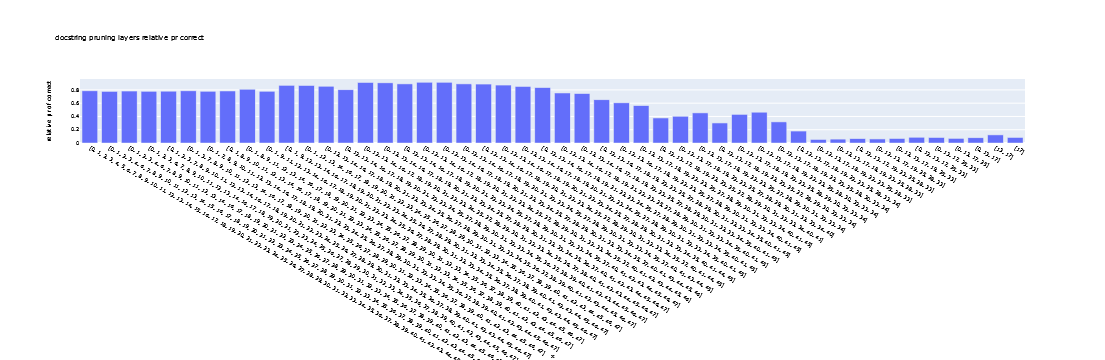

In [87]:



import pandas as pd
import plotly.express as px
def bar_chart(data, x_labels, y_label, title, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

bar_chart(history_stats[:,0], x_labels=[str(x) for x in history], y_label='relative pr of correct', title=f"{data_type} pruning layers relative pr correct", font_size=5)
bar_chart(history_stats[:,1], x_labels=[str(x) for x in history], y_label='relative pr of incorrect', title=f"{data_type} pruning layers relative pr incorrect", font_size=5)
bar_chart(history_stats[:,2], x_labels=[str(x) for x in history], y_label='accuracy', title=f"{data_type} pruning layers accuracy", font_size=5)

In [1]:
from importlib import reload
from mamba_lens import HookedMamba
model = HookedMamba.from_pretrained("state-spaces/mamba-370m")

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [88]:
import torch
chosen_layers = [0, 10, 11, 14, 17, 18, 20, 22, 28, 33, 39]

from docstring import docstring_prompt_generator_function, docstring_induction_prompt_generator
from test_data import greater_than_data_generator, IOI_generator, ABC_TEMPLATES, BAC_TEMPLATES, BABA_TEMPLATES, BABA_LONG_TEMPLATES, BABA_LATE_IOS, BABA_EARLY_IOS

num_examples = 500
seed = 30
data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer')

#data = IOI_generator(templates=[BABA_TEMPLATES[0]], tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)

batched_data, batched_correct, batched_incorrect = get_batched_data(data)
#print(batched_data.size(), batched_correct.size(), batched_incorrect.size())

print(eval(model, batched_data, batched_correct, batched_incorrect, only_use_these_layers=chosen_layers, fast_ssm=True, fast_conv=True))



def string(self, event, module, count, current, run, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param [' run'] [' start', ' row', ' response', ' form', ' index', ' query', ' resource', ' output', ' count', ' current', ' event', ' module', ' parser']

def string(self, event, module, count, current, start, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param [' start'] [' row', ' response', ' form', ' index', ' query', ' resource', ' output', ' count', ' current', ' event', ' module', ' parser', ' run']

def instance(self, shape, context, code, index, result, names):
    """faith data screen

    :param code: sum item
    :param index: stock section
    :param [' result'] [' parser', ' old', ' date', ' default', ' size', ' settings', ' status', ' found', ' code', ' index', ' shape', ' context', ' names']
(0.10616207122802734, 0.8938379287719727, 0.104)


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda
Then, Emma and Shelby went to the school. Emma gave a kiss to [' Shelby'] [' Emma']
Then, Emma and Shelby went to the school. Shelby gave a kiss to [' Emma'] [' Shelby']
Then, Marion and Elaine went to the hospital. Marion gave a necklace to [' Elaine'] [' Marion']


200it [01:21,  2.46it/s]


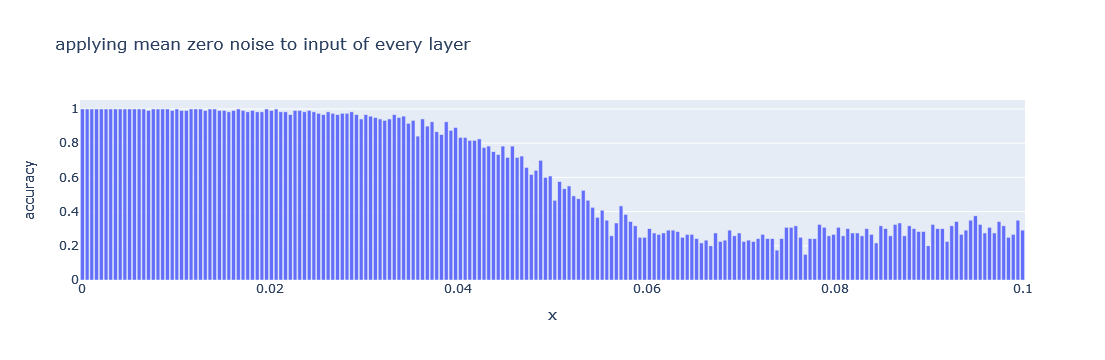

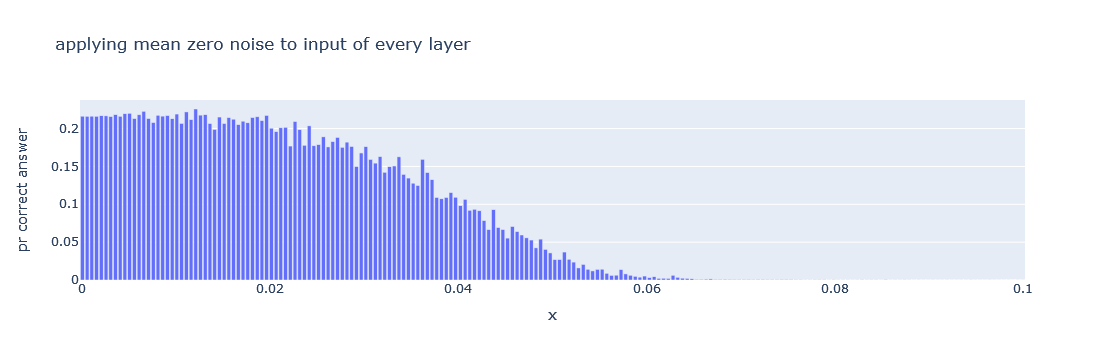

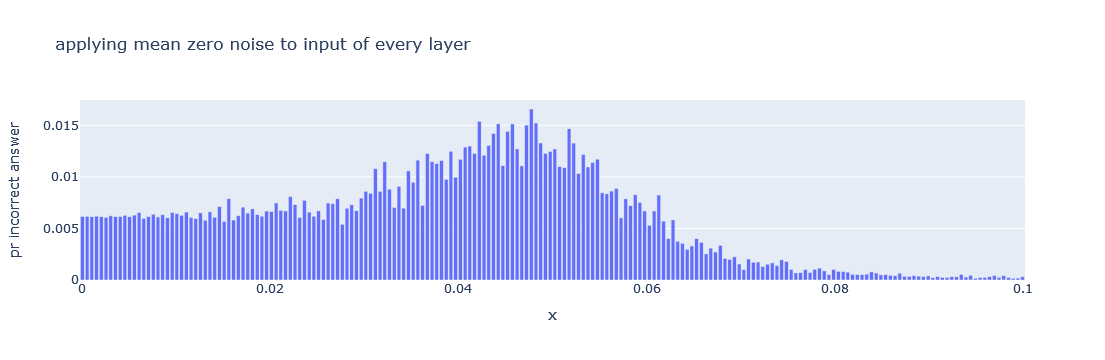

In [1]:
from einops import rearrange
import torch
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
import tqdm
import pandas as pd
import plotly.express as px
from mamba_lens import HookedMamba
from test_data import greater_than_data_generator, IOI_generator, ABC_TEMPLATES, BAC_TEMPLATES, BABA_TEMPLATES, BABA_LONG_TEMPLATES, BABA_LATE_IOS, BABA_EARLY_IOS

model = HookedMamba.from_pretrained("state-spaces/mamba-370m")

torch.set_grad_enabled(False)

seed = 27
num_examples = 120
data = IOI_generator(templates=[BABA_TEMPLATES[0]], tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
batched_data = []
batched_correct = []
batched_incorrect = []
for i, (prompt, corrects, incorrects) in enumerate(data):
    if i < 3:
        print(prompt, corrects, incorrects)
    batched_data.append(torch.tensor(model.tokenizer.encode(prompt), device=model.cfg.device))
    batched_correct.append(model.tokenizer.encode(corrects[0])[0])
    batched_incorrect.append(model.tokenizer.encode(incorrects[0])[0])
batched_data = torch.stack(batched_data)
batched_correct = torch.tensor(batched_correct)
batched_incorrect = torch.tensor(batched_incorrect)

points = list(torch.linspace(0, 0.1, 200))
output_accuracies = torch.zeros([len(points)], device=model.cfg.device)
output_prs = torch.zeros([len(points)], device=model.cfg.device)
output_prs_incorrect = torch.zeros([len(points)], device=model.cfg.device)


def resid_pre_hook(
    resid_pre: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    noise_std: Float,
) -> Float[torch.Tensor, "B L D"]:
    noise = torch.empty(resid_pre.size(), device=model.cfg.device).normal_(mean=0,std=noise_std)
    return resid_pre + noise

for i, noise_std in tqdm.tqdm(enumerate(points)):
    hook = partial(resid_pre_hook, noise_std=noise_std)
    hooks = []
    for layer in range(model.cfg.n_layers):
        hooks.append((f"blocks.{layer}.hook_resid_pre", hook))
    
    logits = model.run_with_hooks(input=batched_data, fwd_hooks=hooks, fast_ssm=True, fast_conv=True)[:,-1]
    prs = torch.nn.functional.softmax(logits, dim=1)
    correct_prs = prs[torch.arange(num_examples),batched_correct]
    incorrect_prs = prs[torch.arange(num_examples),batched_incorrect]
    correct_logits = logits[torch.arange(num_examples),batched_correct]
    incorrect_logits = logits[torch.arange(num_examples),batched_incorrect]
    num_correct = torch.sum(correct_logits > incorrect_logits)
    output_accuracies[i] = num_correct/float(num_examples)
    output_prs[i] = torch.mean(correct_prs)
    output_prs_incorrect[i] = torch.mean(incorrect_prs)

def bar_chart(data, x_labels, y_label, title, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

bar_chart(data=output_accuracies, x_labels=points, y_label='accuracy', title='applying mean zero noise to input of every layer')
bar_chart(data=output_prs, x_labels=points, y_label='pr correct answer', title='applying mean zero noise to input of every layer')
bar_chart(data=output_prs_incorrect, x_labels=points, y_label='pr incorrect answer', title='applying mean zero noise to input of every layer')

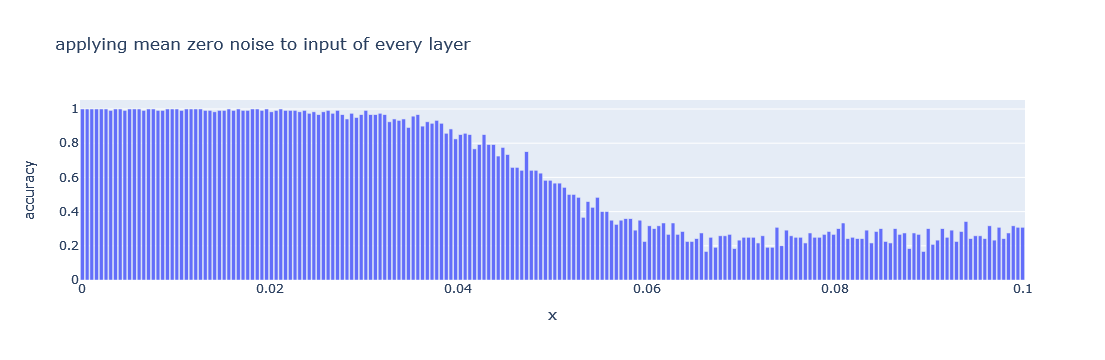

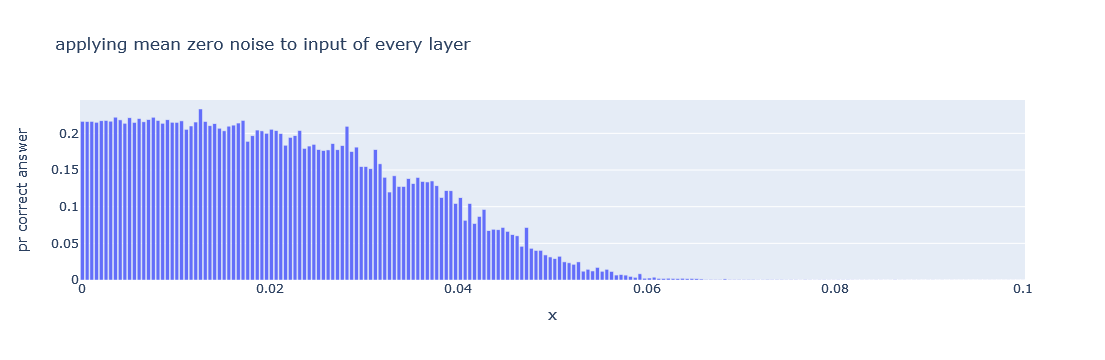

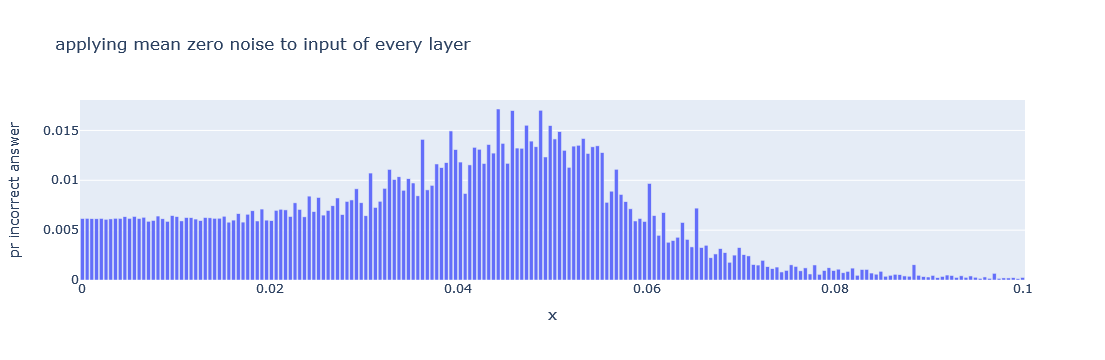